# Accumulation Opportunity
### Riya Sheth

riyasheth@uchicago.edu

### Index:
0. Introduction

1. Imports

2. Data Cleaning Methods

3. Data Importing and Analysis

4. VWAP Algorithm

5. Demo of the VWAP Algorithm for the 6 cases.

6. Analysis of the VWAP Algorithm:
   
   a. Yearly
   
   b. Daily
   
   c. Buying vs Selling
   
   d. Across the three pairs
   
   e. Different parameters such as Q, participation rate, chunk rate

## INTRODUTION

### Aim of the Excerise:
1. To see how to accumulate a large order of cryptocurrencies without disruption of the market.
2. To test and investugate the liquidity, prices, transaction costs associated to the cryptocurrencies

### VWAP Participation Algorithm Description:
1. Set an aribtrary arrival time, a reasonable Q such as 1 bitcoin, low participation_rate like 3% or 0.03 and a time constraint between 1-15 minutes.
2. From the arrival time, start your trading strategy by buying/selling the participation_rate times the volume of the worst price in a time interval of 0.1 seconds. Keep repeating till the Q is reached or the time_limit is exceeded.
3. From there calculate the various metrics such as Value Weight Average Price and the Market Value Weight Average Price. The formula is given below:

VWAP = (Sum of (Price * Volume Traded)) / (Total Volume Traded)

Market VWAP = (Sum of (Price * Volume for All Possible Trades)) / (Total Volume for Possible Trades)

### IMPORTS

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import statistics
import statsmodels.api as sm
quandl.ApiConfig.api_key= "dSEK8-iUMxdiDUyrcPdc"
import warnings
from datetime import timedelta
from sklearn import preprocessing
from datetime import datetime
import random
warnings.filterwarnings('ignore')

### Data Cleaning Methods

In [3]:
def convert_timestamp_to_datetime(x):
    dt= pd.to_datetime(x)
    return dt

In [4]:
def add_datetime_column_to_df(df):
    df['date']= df['timestamp_utc_nanoseconds'].apply(convert_timestamp_to_datetime)
    return df

In [5]:
def split_dataframe(df):
    buying_df = df[df.Side > 0]
    selling_df= df[df.Side < 0]
    return buying_df, selling_df

In [6]:
def handle_same_price_and_same_time_data(df):
    """
    If two data rows have the same price and the same time, then the data row with the lowest volume is chosen
    """
    counter=0
    while counter <len(df)-1:
        if df['PriceMillionths'][counter]== df['PriceMillionths'][counter+1] and df['date'][counter]== df['date'][counter+1]:
            if df['SizeBillionths'][counter]>df['SizeBillionths'][counter+1]:
                df['SizeBillionths'][counter]= df['SizeBillionths'][counter+1]
            else:
                df['SizeBillionths'][counter+1]= df['SizeBillionths'][counter]
        counter= counter+1
    return df

In [7]:
def group_data(df):  
    constant= df['date'][0]
    group_list=[0]
    counter_group=0
    
    for i in range(1, len(df)):
        if (df['date'][i]- constant).days==0 and (df['date'][i]- constant).seconds==0 and (df['date'][i]- constant).microseconds < 100000:
            group_list.append(counter_group)
        else:
            counter_group= counter_group+1
            constant= df['date'][i]
            group_list.append(counter_group)
                   
    df['group']= group_list
    return df   

In [8]:
def convert_price_and_size_to_units(df):
    df['price']= df['worst_price']/10**6
    df['size']= df['worst_price_corresponding_volume']/10**9
    return df

In [9]:
def get_worst_price_buying(df):
    """
    If there is a flurry of trades, that is if there are mutiple trades in a time interval of 0.1 seconds, 
    the worst price is chosen to be the highest price if you are buying.
    """
    worst_price_list_buying=[]
    worst_price_list_corresponding_volume=[]
    current_group=0
    position=0
    
    while position<len(df):
        
        group_size=0
        worst=0
        worst_volume=0
        
        while  position<len(df) and df['group'][position] == current_group:
            
            if df['PriceMillionths'][position] > worst:
                worst= df['PriceMillionths'][position]
                worst_volume= df['SizeBillionths'][position]
            if df['PriceMillionths'][position]== worst:
                if worst_volume> df['SizeBillionths'][position]:
                    worst= df['PriceMillionths'][position]
                    worst_volume= df['SizeBillionths'][position]    
            position= position+1
            group_size= group_size+1
           
        current_group= current_group+1
        for i in range(0, group_size):
            worst_price_list_buying.append(worst)
            worst_price_list_corresponding_volume.append(worst_volume)
        
    df['worst_price']=  worst_price_list_buying 
    df['worst_price_corresponding_volume']= worst_price_list_corresponding_volume
    return df 

In [10]:
def get_worst_price_selling(df):
    """
    If there is a flurry of trades, that is if there are mutiple trades in a time interval of 0.1 seconds, 
    the worst price is chosen to be the lowest price if you are selling.
    """
    worst_price_list_selling=[]
    worst_price_list_corresponding_volume=[]
    current_group=0
    position=0
    
    while position<len(df):
        
        group_size=0
        worst=df['PriceMillionths'][position]
        worst_volume=df['PriceMillionths'][position]
        
        while  position<len(df) and df['group'][position] == current_group:
            if df['PriceMillionths'][position]<=worst:
                worst= df['PriceMillionths'][position]
                worst_volume= df['SizeBillionths'][position]
            if df['PriceMillionths'][position]== worst:
                if worst_volume> df['SizeBillionths'][position]:
                    worst= df['PriceMillionths'][position]
                    worst_volume= df['SizeBillionths'][position]
            position= position+1
            group_size= group_size+1
           
        current_group= current_group+1
        for i in range(0, group_size):
            worst_price_list_selling.append(worst)
            worst_price_list_corresponding_volume.append(worst_volume)
        
        
    df['worst_price']=  worst_price_list_selling
    df['worst_price_corresponding_volume']= worst_price_list_corresponding_volume
    return df 

### DATA IMPORTING AND PREPROCESSING
We do need the books data in the algorithm. The data from the books file was used to generate the side.

In [11]:
trades_btc_usd_2021= pd.read_csv('trades_narrow_BTC-USD_2021.delim', delimiter='\t')
trades_btc_usd_2022= pd.read_csv('trades_narrow_BTC-USD_2022.delim', delimiter='\t')
trades_btc_usd_2023= pd.read_csv('trades_narrow_BTC-USD_2023.delim', delimiter='\t')

trades_eth_btc_2021= pd.read_csv('trades_narrow_ETH-BTC_2021.delim', delimiter='\t')
trades_eth_btc_2022= pd.read_csv('trades_narrow_ETH-BTC_2022.delim', delimiter='\t')
trades_eth_btc_2023= pd.read_csv('trades_narrow_ETH-BTC_2023.delim', delimiter='\t')

trades_eth_usd_2021= pd.read_csv('trades_narrow_ETH-USD_2021.delim', delimiter='\t')
trades_eth_usd_2022= pd.read_csv('trades_narrow_ETH-USD_2022.delim', delimiter='\t')
trades_eth_usd_2023= pd.read_csv('trades_narrow_ETH-USD_2023.delim', delimiter='\t')

In [12]:
trades_btc_usd= pd.concat([trades_btc_usd_2021, trades_btc_usd_2022, trades_btc_usd_2023], axis=0)
trades_eth_btc= pd.concat([trades_eth_btc_2021, trades_eth_btc_2022, trades_eth_btc_2023], axis=0)
trades_eth_usd= pd.concat([trades_eth_usd_2021, trades_eth_usd_2022, trades_eth_usd_2023], axis=0)

trades_btc_usd= trades_btc_usd.reset_index(drop= True)
trades_eth_btc= trades_eth_btc.reset_index(drop= True)
trades_eth_usd= trades_eth_usd.reset_index(drop= True)

In [13]:
trades_btc_usd= add_datetime_column_to_df(trades_btc_usd)
trades_eth_btc= add_datetime_column_to_df(trades_eth_btc)
trades_eth_usd= add_datetime_column_to_df(trades_eth_usd)

In [14]:
trades_btc_usd= handle_same_price_and_same_time_data(trades_btc_usd)
trades_eth_btc= handle_same_price_and_same_time_data(trades_eth_btc)
trades_eth_usd= handle_same_price_and_same_time_data(trades_eth_usd)

In [15]:
trades_btc_usd_buying, trades_btc_usd_selling= split_dataframe(trades_btc_usd)
trades_eth_btc_buying, trades_eth_btc_selling= split_dataframe(trades_eth_btc)
trades_eth_usd_buying, trades_eth_usd_selling= split_dataframe(trades_eth_usd)

In [16]:
trades_btc_usd_buying= trades_btc_usd_buying.reset_index(drop= True)
trades_btc_usd_selling= trades_btc_usd_selling.reset_index(drop= True)

trades_eth_btc_buying= trades_eth_btc_buying.reset_index(drop= True)
trades_eth_btc_selling= trades_eth_btc_selling.reset_index(drop= True)

trades_eth_usd_buying= trades_eth_usd_buying.reset_index(drop= True)
trades_eth_usd_selling= trades_eth_usd_selling.reset_index(drop= True)

In [17]:
trades_btc_usd_buying= group_data(trades_btc_usd_buying)
trades_btc_usd_selling= group_data(trades_btc_usd_selling)

trades_eth_btc_buying= group_data(trades_eth_btc_buying)
trades_eth_btc_selling= group_data(trades_eth_btc_selling)

trades_eth_usd_buying= group_data(trades_eth_usd_buying)
trades_eth_usd_selling= group_data(trades_eth_usd_selling)

In [18]:
trades_btc_usd_buying= get_worst_price_buying(trades_btc_usd_buying)
trades_btc_usd_selling= get_worst_price_selling(trades_btc_usd_selling)

trades_eth_btc_buying= get_worst_price_buying(trades_eth_btc_buying)
trades_eth_btc_selling= get_worst_price_selling(trades_eth_btc_selling)

trades_eth_usd_buying= get_worst_price_buying(trades_eth_usd_buying)
trades_eth_usd_selling= get_worst_price_selling(trades_eth_usd_selling) 

In [19]:
trades_btc_usd_buying= convert_price_and_size_to_units(trades_btc_usd_buying)
trades_btc_usd_selling= convert_price_and_size_to_units(trades_btc_usd_selling)

trades_eth_btc_buying= convert_price_and_size_to_units(trades_eth_btc_buying)
trades_eth_btc_selling= convert_price_and_size_to_units(trades_eth_btc_selling)

trades_eth_usd_buying= convert_price_and_size_to_units(trades_eth_usd_buying)
trades_eth_usd_selling= convert_price_and_size_to_units(trades_eth_usd_selling)

In [20]:
trades_btc_usd_buying= trades_btc_usd_buying.drop(['received_utc_nanoseconds', 'timestamp_utc_nanoseconds',  'Side', 'worst_price', 'worst_price_corresponding_volume' ], axis=1 )
trades_btc_usd_selling= trades_btc_usd_selling.drop(['received_utc_nanoseconds', 'timestamp_utc_nanoseconds',  'Side', 'worst_price', 'worst_price_corresponding_volume' ], axis=1 )

trades_eth_btc_buying= trades_eth_btc_buying.drop(['received_utc_nanoseconds', 'timestamp_utc_nanoseconds',  'Side', 'worst_price', 'worst_price_corresponding_volume' ], axis=1 )
trades_eth_btc_selling= trades_eth_btc_selling.drop(['received_utc_nanoseconds', 'timestamp_utc_nanoseconds', 'Side', 'worst_price', 'worst_price_corresponding_volume' ], axis=1 )

trades_eth_usd_buying= trades_eth_usd_buying.drop(['received_utc_nanoseconds', 'timestamp_utc_nanoseconds', 'Side', 'worst_price', 'worst_price_corresponding_volume' ], axis=1 )
trades_eth_usd_selling= trades_eth_usd_selling.drop(['received_utc_nanoseconds', 'timestamp_utc_nanoseconds',  'Side', 'worst_price', 'worst_price_corresponding_volume' ], axis=1 )

In [21]:
trades_btc_usd_buying= trades_btc_usd_buying.set_index('date')
trades_btc_usd_selling= trades_btc_usd_selling.set_index('date')

trades_eth_btc_buying= trades_eth_btc_buying.set_index('date')
trades_eth_btc_selling= trades_eth_btc_selling.set_index('date')

trades_eth_usd_buying= trades_eth_usd_buying.set_index('date')
trades_eth_usd_selling= trades_eth_usd_selling.set_index('date')

In [22]:
trades_btc_usd= trades_btc_usd.set_index('date')
trades_eth_btc= trades_eth_btc.set_index('date')
trades_eth_usd= trades_eth_usd.set_index('date')

In [23]:
trades_btc_usd_buying.head()

,PriceMillionths,SizeBillionths,group,price,size
date,,,,,
2021-04-10 21:28:53.470961,59119960000,12790000,0,59122.08,0.003798
2021-04-10 21:28:53.470961,59122080000,3798090,0,59122.08,0.003798
2021-04-10 21:28:53.557380,59119960000,4517350,0,59122.08,0.003798
2021-04-10 21:28:53.596148,59119960000,2524570,1,59119.96,0.002525
2021-04-10 21:28:54.064537,59119960000,555530,2,59119.96,0.000556


This is the data used for buying bitcoins in US dollars.

In [24]:
trades_btc_usd_selling.head()

,PriceMillionths,SizeBillionths,group,price,size
date,,,,,
2021-04-10 21:28:52.515484,59120710000,9701240,0,59120.71,0.009701
2021-04-10 21:28:52.515484,59125070000,8122450,0,59120.71,0.009701
2021-04-10 21:28:52.989553,59119950000,6563880,1,59119.95,0.016996
2021-04-10 21:28:52.989553,59125070000,614120,1,59119.95,0.016996
2021-04-10 21:28:53.074765,59119950000,16995890,1,59119.95,0.016996


This is the data used for selling bitcoins in US dollars.

In [25]:
trades_eth_btc_buying.head()

,PriceMillionths,SizeBillionths,group,price,size
date,,,,,
2021-04-10 21:28:57.864544,35700,29801980,0,0.03570,0.029802
2021-04-10 21:29:03.793909,35700,4641070,1,0.03570,0.004641
2021-04-10 21:29:15.053606,35710,1000000,2,0.03572,0.231356
2021-04-10 21:29:15.053606,35720,231355690,2,0.03572,0.231356
2021-04-10 21:29:15.545750,35720,76002090,3,0.03572,0.076002


This is the data used for buying Ethereum in Bitcoins.

In [26]:
trades_eth_btc_selling.head()

,PriceMillionths,SizeBillionths,group,price,size
date,,,,,
2021-04-10 21:28:57.157544,35690,1000000,0,0.03569,0.001000
2021-04-10 21:29:20.091650,35710,4748690,1,0.03571,0.004749
2021-04-10 21:29:27.165092,35710,237902400,2,0.03571,0.237902
2021-04-10 21:29:42.538197,35720,47422920,3,0.03572,0.047423
2021-04-10 21:29:47.958198,35720,3217240,4,0.03572,0.003217


This is the data used for selling Ethereum in Bitcoins.

In [27]:
trades_eth_usd_buying.head()

,PriceMillionths,SizeBillionths,group,price,size
date,,,,,
2021-04-10 21:28:54.547039,2109000000,499500000,0,2109.0,0.499500
2021-04-10 21:28:54.797956,2109000000,36208850,1,2109.0,0.036209
2021-04-10 21:28:55.123831,2109000000,499500000,2,2109.0,0.499500
2021-04-10 21:28:55.704667,2109000000,499400000,3,2109.0,0.499400
2021-04-10 21:28:56.302068,2109000000,499400000,4,2109.0,0.499400


This is the data used for buying Ethereum in USD.

In [28]:
trades_eth_usd_selling.head()

,PriceMillionths,SizeBillionths,group,price,size
date,,,,,
2021-04-10 21:28:56.621472,2108980000,533383430,0,2108.98,0.533383
2021-04-10 21:28:56.621472,2108990000,653788470,0,2108.98,0.533383
2021-04-10 21:28:57.740374,2108990000,1295228410,1,2108.99,1.295228
2021-04-10 21:29:00.996124,2108990000,55794960,2,2108.99,0.055795
2021-04-10 21:29:01.644370,2108990000,100816760,3,2108.99,0.100817


This is the data used for selling Ethereum in USD.

### DATA ANALYSIS

<AxesSubplot: >

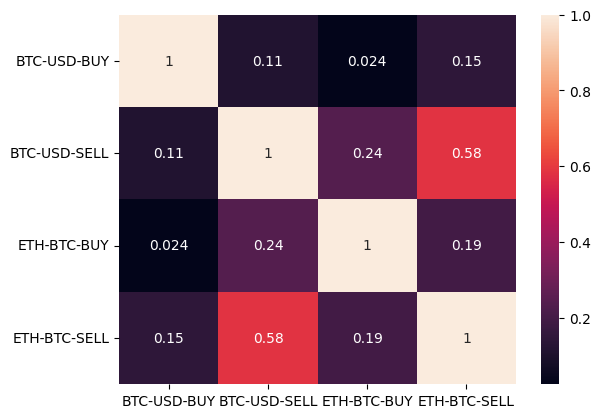

In [54]:
"""
Checking the correlation between the prices of the different pairs

"""
correlation_df= pd.DataFrame()
correlation_df.flags.allows_duplicate_labels = False

correlation_df= correlation_df.loc[~correlation_df.index.duplicated(), :]
a= trades_eth_usd_buying['price'][0:1000]
b= trades_eth_usd_selling['price'][0:1000]
c= trades_eth_btc_buying['price'][0:1000]
d= trades_eth_btc_selling['price'][0:1000]
e= trades_btc_usd_buying['price'][0:1000]
f= trades_btc_usd_selling['price'][0:1000]


correlation_df['BTC-USD-BUY']= list(a)
correlation_df['BTC-USD-SELL']= list(b)
correlation_df['ETH-BTC-BUY']= list(c)
correlation_df['ETH-BTC-SELL']= list(d)
correlation_df['BTC-USD-BUY']= list(e)
correlation_df['BTC-USD-SELL']= list(f)

corr_matrix = correlation_df.corr()
sns.heatmap(corr_matrix, annot=True)

This shows that bitcoin, etheruem and us dollars have a triangular relationship, each currency affects the value of the others. Bitcoin and Ethereum, as cryptocurrencies, have their own independent value and are not directly pegged to the USD. However, their value can be influenced by a variety of factors, including market sentiment, adoption, and regulatory developments, and the demand for these cryptocurrencies. The relationship between BTC, USD, and ETH is complex and interdependent and we will try to investigate this relationship in the below code.

### Algorithm

In [55]:
 def vwap_algorithm(Q, arrival_time, participation_rate, df, time_limit, df_all, crypto_to_currency=True):
    

    current_quantity=0
    position= 0
    price_list=[]
    time_trade_executed=[]
    volume_list=[]
    end_time=0
    total_time=0
    transaction_fees=[]
    
    df= df.loc[arrival_time: ]
    
    if crypto_to_currency== True:
        transaction_fees_rate= 0.5/100
    else:
        transaction_fees_rate= 0.1/100
    
    current_time= df.index[position]
    
    while current_quantity<Q and position< len(df) and (current_time-arrival_time).seconds <= time_limit:
        
        temp= current_quantity+ participation_rate* df['size'][position]
        if temp>Q:
            current_quantity= Q
            volume_list.append(Q- current_quantity)
        else:
            volume_list.append(participation_rate*df['size'][position])
            current_quantity= current_quantity+ participation_rate* df['size'][position]
        
        price_list.append(df['price'][position])
        time_trade_executed.append(df.index[position])
        
        
        transaction_fees.append(df['price'][position]*volume_list[-1]*transaction_fees_rate)#trade notional
        current_group= df['group'][position]
        
        while position< len(df) and current_group== df['group'][position]:
            position=position+1
        if position>=len(df):
            current_time= df.index[position-1]
        else:
            current_time= df.index[position]

        

    if current_quantity == Q or (current_time-arrival_time).seconds <= time_limit :
        end_time= df.index[position-1]
        total_time= df.index[position-1]- arrival_time
    else:
        total_time= -1
        return [], [], -1, 0, 0, [], [], 0, 0, 0, 0, 0
        
    trading_frequency= len(price_list)/len(df.loc[arrival_time: end_time])
    notional= [price_list*volume_list for price_list,volume_list in zip(price_list,volume_list)]
    vwap= sum(notional)/sum(volume_list)
    
    df_all_temp= df.loc[arrival_time:end_time]
    price_list_all= list(df_all_temp['PriceMillionths']/10**6)
    volume_list_all= list(df_all_temp['SizeBillionths']/10**9)
    notional_all= [price_list_all*volume_list_all for price_list_all,volume_list_all in zip(price_list_all,volume_list_all)]
    mvwap= sum(notional_all)/sum(volume_list_all)
    
    new_current_quantity=0
    position= 0
    current_time= df.index[position]
    while position< len(df) and new_current_quantity <=Q:
        new_current_quantity= new_current_quantity+ df['SizeBillionths'][position]/10**9
        position=position+1
    new_total_time= (df.index[position]- current_time).seconds
    if new_total_time==0:
        if ((df.index[position]- current_time).microseconds)==0:
            theoretical_accumulation_rate=Q*100 #arbitary high number
        else:
            theoretical_accumulation_rate= Q/(((df.index[position]- current_time).microseconds)/6000)
            
    else:   
        theoretical_accumulation_rate= Q/(new_total_time/60)

    return price_list, volume_list, total_time, arrival_time, end_time, time_trade_executed, transaction_fees, trading_frequency, notional, vwap, mvwap, theoretical_accumulation_rate

### Demo - Buy Bitcoin to USD

In [56]:
Q=1
participation_rate= 0.06
time_limit= 15*60
arrival_time= trades_btc_usd_buying.index[0]

price_list, volume_list, total_time, arrival_time, end_time, time_trade_executed, transaction_fees, trading_frequency, notional, vwap, mvwap, theoretical_accumulation_rate= vwap_algorithm(Q, arrival_time, participation_rate, trades_btc_usd_buying, time_limit, trades_btc_usd, crypto_to_currency=True)

print('BUYING BITCOINS IN USD')
print('Start-Time: ', arrival_time)
print('End-Time: ', end_time)
print('Arrival Price: ', price_list[0])
print('End Price: ', price_list[-1])
print('Average Price: ', sum(price_list)/len(price_list))
print('VWAP: ', vwap)
print('Market VWAP: ', mvwap)
print('Transaction Cost: ', sum(transaction_fees))
print('Total Cost: ', sum(notional))
print('Trading Frequency: ', trading_frequency)
print('Accumulation Rate Minutes: ', Q/(total_time.seconds/60))
print('Theoretical Accumulation Rate Minutes: ', theoretical_accumulation_rate)
print('Transaction Time: ', total_time)

BUYING BITCOINS IN USD
Start-Time:  2021-04-10 21:28:53.470961
End-Time:  2021-04-10 21:41:35.951075
Arrival Price:  59122.08
End Price:  59077.31
Average Price:  59113.908114919446
VWAP:  59124.48871327347
Market VWAP:  59130.81800683151
Transaction Cost:  295.5683748718079
Total Cost:  59113.67497436169
Trading Frequency:  0.6757493188010899
Accumulation Rate Minutes:  0.07874015748031496
Theoretical Accumulation Rate Minutes:  5.454545454545455
Transaction Time:  0 days 00:12:42.480114


Text(0.5, 1.0, 'Buying Bitcoin against USD')

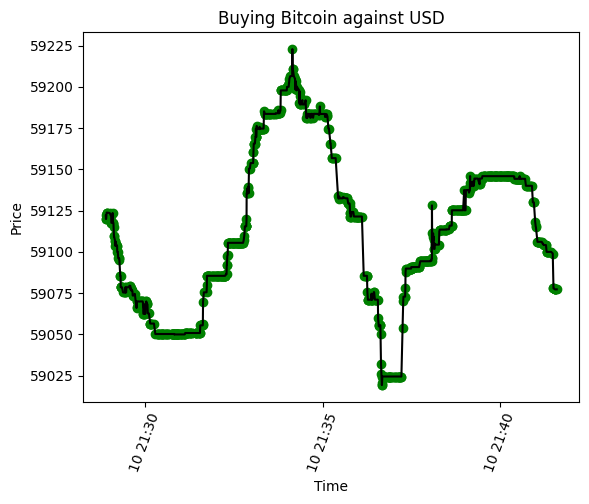

In [58]:
graph_df= trades_btc_usd_buying.loc[arrival_time: end_time]
plt.rcParams['figure.dpi'] = 100
plt.plot(graph_df.index, graph_df['price'], color= 'black')
plt.scatter(time_trade_executed, price_list, color='green')
plt.xticks(rotation=70)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Buying Bitcoin against USD')

Here, we have noticed that there are a lot of trades in a short span of time or in the other words there are frequent flurry of trades. The actual accumulation rate is about 400 times less than the theoretical rate, hence it shows that there are a lot of trades which are skipped. The trading frequency is also 66% even though we could participate in every trade but for the 0.1 seconds condition.

We are buying a security and VWAP is lower than the Market VWAP. This maybe a good sign. A lower VWAP compared to the Market VWAP could indicate that the security is trading at a discount compared to the overall market, which could suggest lower demand for the security. This could be a buying opportunity if the individual believes that the security is undervalued and has the potential for future growth. However, the difference between the two metrics are not that significant

### Demo- Sell Bitcoin to USD

In [59]:
Q=1
participation_rate= 0.06
time_limit= 15*60
arrival_time= trades_btc_usd_selling.index[0]

price_list, volume_list, total_time, arrival_time, end_time, time_trade_executed, transaction_fees, trading_frequency, notional, vwap, mvwap, theoretical_accumulation_rate= vwap_algorithm(Q, arrival_time, participation_rate, trades_btc_usd_selling, time_limit, trades_btc_usd, crypto_to_currency=True)

print('SELLING BITCOINS IN USD')
print('Start-Time: ', arrival_time)
print('End-Time: ', end_time)
print('Arrival Price: ', price_list[0])
print('End Price: ', price_list[-1])
print('Average Price: ', sum(price_list)/len(price_list))
print('VWAP: ', vwap)
print('Market VWAP: ', mvwap)
print('Transaction Cost: ', sum(transaction_fees))
print('Total Cost: ', sum(notional))
print('Trading Frequency: ', trading_frequency)
print('Accumulation Rate Minutes: ', Q/(total_time.seconds/60))
print('Theoretical Accumulation Rate Minutes: ', theoretical_accumulation_rate)
print('Transaction Time: ', total_time)

SELLING BITCOINS IN USD
Start-Time:  2021-04-10 21:28:52.515484
End-Time:  2021-04-10 21:43:22.943572
Arrival Price:  59120.71
End Price:  59130.09
Average Price:  59103.659387755
VWAP:  59106.07643013668
Market VWAP:  59096.68838044253
Transaction Cost:  295.07099429798245
Total Cost:  59014.198859596465
Trading Frequency:  0.6572280178837556
Accumulation Rate Minutes:  0.06896551724137931
Theoretical Accumulation Rate Minutes:  3.1578947368421053
Transaction Time:  0 days 00:14:30.428088


Text(0.5, 1.0, 'Selling Bitcoin against USD')

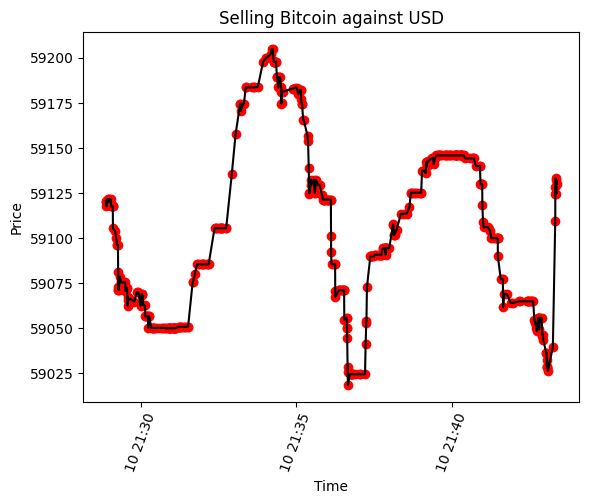

In [61]:
graph_df= trades_btc_usd_selling.loc[arrival_time: end_time]
plt.rcParams['figure.dpi'] = 100
plt.plot(graph_df.index, graph_df['price'], color= 'black')
plt.scatter(time_trade_executed, price_list, color='red')
plt.xlabel('Time')
plt.xticks(rotation=70)
plt.ylabel('Price')
plt.title('Selling Bitcoin against USD')

Comparing it to the above demo we had for buying the bitcoin. We realized that it may take more time to sell a Bitcoin than to buy one due to various factors such as the volatility of the cryptocurrency market, the volume of trades, and the trading platform used.
We are selling a security and its Volume Weighted Average Price (VWAP) is higher than the Market VWAP, it may be a good sign.A higher VWAP compared to the Market VWAP could indicate that the security is trading at a premium compared to the overall market, which could suggest strong demand for the security. If we are looking to sell the security, this could indicate that the market is willing to pay a higher price, and we may be able to realize a higher return on your investment. However, again here the difference is not that tremendous

### Demo Buying ETH against Bitcoin

In [62]:
Q=1
participation_rate= 0.06
time_limit= 15*60
arrival_time= trades_eth_btc_buying.index[0]

price_list, volume_list, total_time, arrival_time, end_time, time_trade_executed, transaction_fees, trading_frequency, notional, vwap, mvwap, theoretical_accumulation_rate= vwap_algorithm(Q, arrival_time, participation_rate, trades_eth_btc_buying, time_limit, trades_eth_btc, crypto_to_currency=False)

print('BUYING ETH IN BITCOIN')
print('Start-Time: ', arrival_time)
print('End-Time: ', end_time)
print('Arrival Price: ', price_list[0])
print('End Price: ', price_list[-1])
print('Average Price: ', sum(price_list)/len(price_list))
print('VWAP: ', vwap)
print('Market VWAP: ', mvwap)
print('Transaction Cost: ', sum(transaction_fees))
print('Total Cost: ', sum(notional))
print('Trading Frequency: ', trading_frequency)
print('Accumulation Rate Minutes: ', Q/(total_time.seconds/60))
print('Theoretical Accumulation Rate Minutes: ', theoretical_accumulation_rate)
print('Transaction Time: ', total_time)

BUYING ETH IN BITCOIN
Start-Time:  2021-04-10 21:28:57.864544
End-Time:  2021-04-10 21:32:01.926800
Arrival Price:  0.0357
End Price:  0.03567
Average Price:  0.03569958333333333
VWAP:  0.03569340468592156
Market VWAP:  0.03568630308514589
Transaction Cost:  3.1697782168374006e-05
Total Cost:  0.03169778216837401
Trading Frequency:  0.9230769230769231
Accumulation Rate Minutes:  0.32608695652173914
Theoretical Accumulation Rate Minutes:  0.5714285714285714
Transaction Time:  0 days 00:03:04.062256


Text(0.5, 1.0, 'Buying ETH against BitCoins')

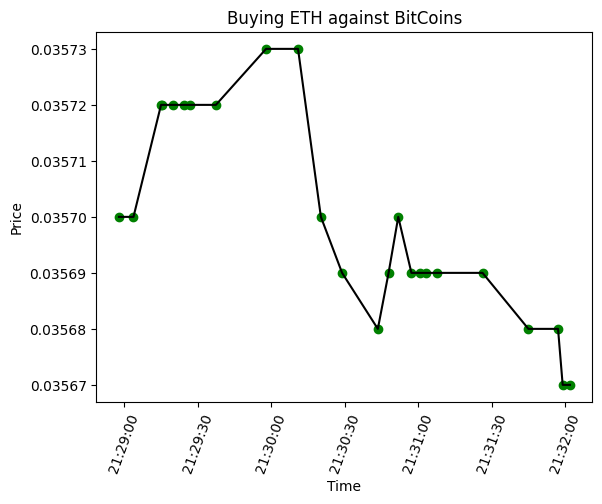

In [63]:
graph_df= trades_eth_btc_buying.loc[arrival_time: end_time]
plt.rcParams['figure.dpi'] = 100
plt.plot(graph_df.index, graph_df['price'], color= 'black')
plt.scatter(time_trade_executed, price_list, color='green')
plt.xlabel('Time')
plt.xticks(rotation=70)
plt.ylabel('Price')
plt.title('Buying ETH against BitCoins')

As compared to the bitcoin against usd, we realise that the number of orders or trades is not as many. There are fewer trades but the size of the those trades seem relatively large because the time for completion of trade of the same quantity as above is significantly lower, almost 5 times less. This could also mean that the orders are spread out and they don't come in a flurry like bitcoins against usd. 
Here, the mvwap and vwap are very similar, hence no comment can be made.


### Demo Selling ETH against BitCoin

In [64]:
Q=1
participation_rate= 0.06
time_limit= 15*60
arrival_time= trades_eth_btc_selling.index[0]

price_list, volume_list, total_time, arrival_time, end_time, time_trade_executed, transaction_fees, trading_frequency, notional, vwap, mvwap, theoretical_accumulation_rate= vwap_algorithm(Q, arrival_time, participation_rate, trades_eth_btc_selling, time_limit, trades_eth_btc, crypto_to_currency=False)

print('SELLING ETH IN BITCOIN')
print('Start-Time: ', arrival_time)
print('End-Time: ', end_time)
print('Arrival Price: ', price_list[0])
print('End Price: ', price_list[-1])
print('Average Price: ', sum(price_list)/len(price_list))
print('VWAP: ', vwap)
print('Market VWAP: ', mvwap)
print('Transaction Cost: ', sum(transaction_fees))
print('Total Cost: ', sum(notional))
print('Trading Frequency: ', trading_frequency)
print('Accumulation Rate Minutes: ', Q/(total_time.seconds/60))
print('Theoretical Accumulation Rate Minutes: ', theoretical_accumulation_rate)
print('Transaction Time: ', total_time)

SELLING ETH IN BITCOIN
Start-Time:  2021-04-10 21:28:57.157544
End-Time:  2021-04-10 21:43:19.275277
Arrival Price:  0.03569
End Price:  0.03576
Average Price:  0.03569721311475409
VWAP:  0.035698175193849616
Market VWAP:  0.0357234994198511
Transaction Cost:  3.0112672535153997e-05
Total Cost:  0.030112672535154015
Trading Frequency:  0.9384615384615385
Accumulation Rate Minutes:  0.06960556844547564
Theoretical Accumulation Rate Minutes:  0.38216560509554137
Transaction Time:  0 days 00:14:22.117733


Text(0.5, 1.0, 'Selling ETH against BitCoins')

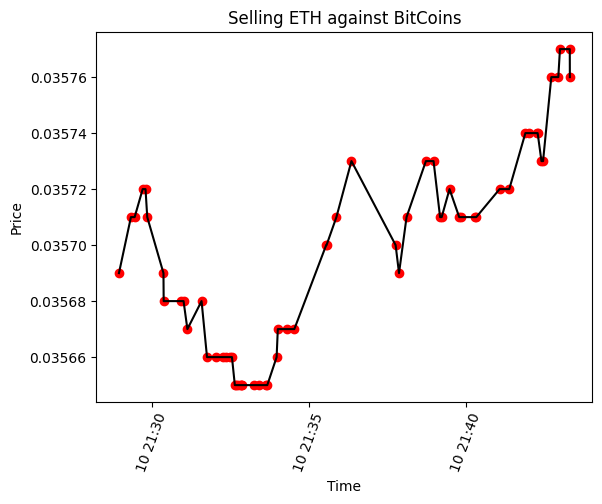

In [65]:
graph_df= trades_eth_btc_selling.loc[arrival_time: end_time]
plt.rcParams['figure.dpi'] = 100
plt.plot(graph_df.index, graph_df['price'], color= 'black')
plt.scatter(time_trade_executed, price_list, color='red')
plt.xlabel('Time')
plt.xticks(rotation=70)
plt.ylabel('Price')
plt.title('Selling ETH against BitCoins')

Here again the selling of ethereum tooka a signifcantly longer time than the buying of etheruem. Here, the mvwap and vwap are very similar, hence no comment can be made. The trading frequency like the selling case is very high, this indicates that there are few trades which come within 0.1 seconds of the previous trade.

### Demo Buying ETH against USD

In [66]:
Q=1
participation_rate= 0.06
time_limit= 15*60
arrival_time= trades_eth_usd_buying.index[0]

price_list, volume_list, total_time, arrival_time, end_time, time_trade_executed, transaction_fees, trading_frequency, notional, vwap, mvwap, theoretical_accumulation_rate= vwap_algorithm(Q, arrival_time, participation_rate, trades_eth_usd_buying, time_limit, trades_eth_usd, crypto_to_currency=True)

print('BUYING ETH IN USD')
print('Start-Time: ', arrival_time)
print('End-Time: ', end_time)
print('Arrival Price: ', price_list[0])
print('End Price: ', price_list[-1])
print('Average Price: ', sum(price_list)/len(price_list))
print('VWAP: ', vwap)
print('Market VWAP: ', mvwap)
print('Transaction Cost: ', sum(transaction_fees))
print('Total Cost: ', sum(notional))
print('Trading Frequency: ', trading_frequency)
print('Accumulation Rate Minutes: ', Q/(total_time.seconds/60))
print('Theoretical Accumulation Rate Minutes: ', theoretical_accumulation_rate)
print('Transaction Time: ', total_time)

BUYING ETH IN USD
Start-Time:  2021-04-10 21:28:54.547039
End-Time:  2021-04-10 21:29:58.850147
Arrival Price:  2109.0
End Price:  2108.95
Average Price:  2108.991176470589
VWAP:  2108.9969667424466
Market VWAP:  2108.993480388054
Transaction Cost:  10.42859670002406
Total Cost:  2085.719340004812
Trading Frequency:  0.8947368421052632
Accumulation Rate Minutes:  0.9375
Theoretical Accumulation Rate Minutes:  60.0
Transaction Time:  0 days 00:01:04.303108


Text(0.5, 1.0, 'Buying ETH against USD')

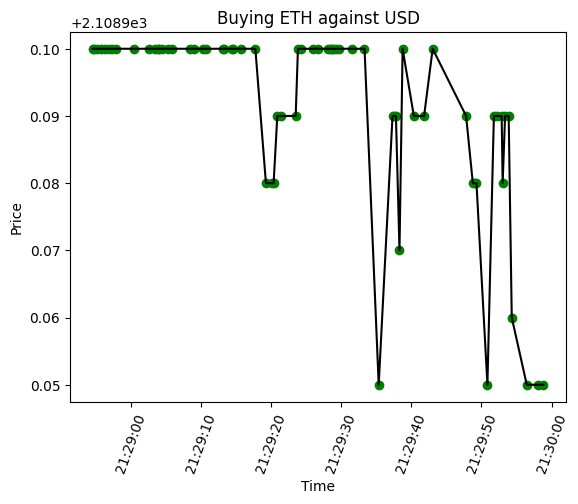

In [67]:
graph_df= trades_eth_usd_buying.loc[arrival_time: end_time]
plt.rcParams['figure.dpi'] = 100
plt.plot(graph_df.index, graph_df['price'], color= 'black')
plt.scatter(time_trade_executed, price_list, color='green')
plt.xlabel('Time')
plt.xticks(rotation=70)
plt.ylabel('Price')
plt.title('Buying ETH against USD')

Here, the mvwap and vwap are very similar, hence no comment can be made.
We realize that the transaction cost while is obviously not as low as the eth to btc case, is much smaller than the case of btc to usd, because the number of trades are smaller. this could also be because the size of the etheruem traded could be higher thn bitcoins

### Demo Selling ETH against USD

In [68]:
Q=1
participation_rate= 0.06
time_limit= 15*60
arrival_time= trades_eth_usd_selling.index[0]

price_list, volume_list, total_time, arrival_time, end_time, time_trade_executed, transaction_fees, trading_frequency, notional, vwap, mvwap, theoretical_accumulation_rate= vwap_algorithm(Q, arrival_time, participation_rate, trades_eth_usd_selling, time_limit, trades_eth_usd, crypto_to_currency=True)

print('SELLING ETH IN USD')
print('Start-Time: ', arrival_time)
print('End-Time: ', end_time)
print('Arrival Price: ', price_list[0])
print('End Price: ', price_list[-1])
print('Average Price: ', sum(price_list)/len(price_list))
print('VWAP: ', vwap)
print('Market VWAP: ', mvwap)
print('Transaction Cost: ', sum(transaction_fees))
print('Total Cost: ', sum(notional))
print('Trading Frequency: ', trading_frequency)
print('Accumulation Rate Minutes: ', Q/(total_time.seconds/60))
print('Theoretical Accumulation Rate Minutes: ', theoretical_accumulation_rate)
print('Transaction Time: ', total_time)

SELLING ETH IN USD
Start-Time:  2021-04-10 21:28:56.621472
End-Time:  2021-04-10 21:30:32.709871
Arrival Price:  2108.98
End Price:  2105.98
Average Price:  2108.3272499999994
VWAP:  2108.254906259147
Market VWAP:  2108.5243125988036
Transaction Cost:  8.016261452255641
Total Cost:  1603.2522904511275
Trading Frequency:  0.625
Accumulation Rate Minutes:  0.625
Theoretical Accumulation Rate Minutes:  60.0
Transaction Time:  0 days 00:01:36.088399


Text(0.5, 1.0, 'Selling ETH against USD')

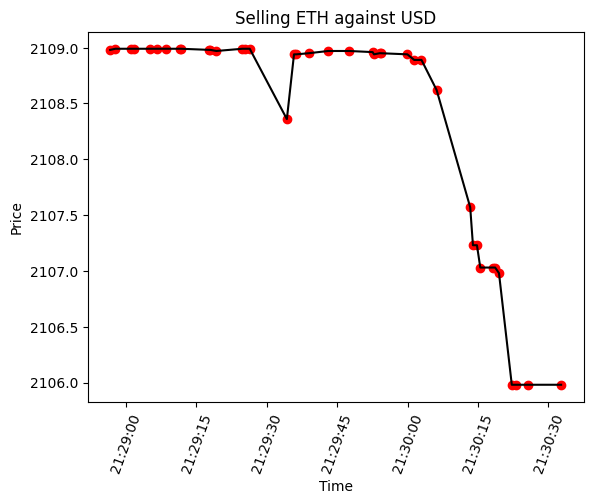

In [69]:
graph_df= trades_eth_usd_selling.loc[arrival_time: end_time]
plt.rcParams['figure.dpi'] = 100
plt.plot(graph_df.index, graph_df['price'], color= 'black')
plt.scatter(time_trade_executed, price_list, color='red')
plt.xlabel('Time')
plt.xticks(rotation=70)
plt.ylabel('Price')
plt.title('Selling ETH against USD')

Hence, by observing the different metrics by giving in the same quantity, we were able to understand the gist of the data in the three pairs, such as btc to usd has the highest number of orders/trades, selling has taken more time than buying.

## RESULTS ANALYSIS

In [70]:
def generate_random(df, crypto_currency, df_full, tl, pr, q, sample_size):
    time_limit= tl 
    participation_rate= pr
    random_list= random.sample(range(1, len(df)), sample_size)
    Q=q
    
    print('Q: ', q)
    print('Time Limit: ', tl)
    print('Participation Rate: ', pr)

    
    start_time_list=[]
    end_time_list=[]
    average_price_list=[]
    arrival_price_list=[]
    end_price_list=[]
    transaction_time_list=[]
    vwap_list=[]
    mvwap_list=[]
    transaction_cost_list=[]
    total_cost_list=[]
    trading_frequency_list=[]
    accumulation_rate_minutes=[]
    theoretical_accumulation_rate_minutes=[]
    transaction_time_list=[]
    
    unsatisfied_counter=0
    

    
    for i in random_list:
        
        arrival_time= df.index[i]
        
        price_list, volume_list, total_time, arrival_time, end_time, time_trade_executed, transaction_fees, trading_frequency, notional, vwap, mvwap, theoretical_accumulation_rate= vwap_algorithm(Q, arrival_time, participation_rate, df, time_limit, df_full, crypto_to_currency=True)


        if total_time ==-1:
            unsatisfied_counter= unsatisfied_counter+1
        else:
            start_time_list.append(arrival_time)
            end_time_list.append(end_time)
            arrival_price_list.append(price_list[0])
            end_price_list.append(price_list[-1])
            average_price_list.append(sum(price_list)/len(price_list))
            vwap_list.append(vwap)
            mvwap_list.append(mvwap)
            transaction_cost_list.append(sum(transaction_fees))
            total_cost_list.append(sum(notional))
            trading_frequency_list.append(trading_frequency)
            if total_time.seconds==0:
                if total_time.microseconds!=0:
                    accumulation_rate_minutes.append( Q/(total_time.microseconds/6000))
                else:
                    accumulation_rate_minutes.append(Q*100)
                
            else:   
                accumulation_rate_minutes.append( Q/(total_time.seconds/60))
            theoretical_accumulation_rate_minutes.append(theoretical_accumulation_rate)
            transaction_time_list.append(total_time)

    rate_of_filling= (sample_size - unsatisfied_counter)/sample_size
    
    df= pd.DataFrame()
    df['Start_Time']= start_time_list
    df['End_Time']= end_time_list
    df['Arrival_Price']= arrival_price_list
    df['End_Price']= end_price_list
    df['Average_Price']= average_price_list
    df['Transaction_Time']= transaction_time_list
    df['VWAP']= vwap_list
    df['Market_VWAP']= mvwap_list
    df['Transaction_Costs']= transaction_cost_list
    df['Total_Cost']= total_cost_list
    df['Trading_Frequency']= trading_frequency_list
    df['Accumulation_Rate']= accumulation_rate_minutes
    df['Theoretical_Accumulation_Rate']= theoretical_accumulation_rate_minutes
    
    return rate_of_filling, df

## Analysing Buying BTC to USD


In [71]:
rate_of_filling, df_btc_to_usd = generate_random(trades_btc_usd_buying, True, trades_btc_usd, 15*60, 0.03, 1, 500)

Q:  1
Time Limit:  900
Participation Rate:  0.03


In [72]:
df_btc_to_usd = df_btc_to_usd.sort_values(by='Start_Time')
df_btc_to_usd = df_btc_to_usd.set_index('Start_Time')
df_btc_to_usd.head()

,End_Time,Arrival_Price,End_Price,Average_Price,Transaction_Time,VWAP,Market_VWAP,Transaction_Costs,Total_Cost,Trading_Frequency,Accumulation_Rate,Theoretical_Accumulation_Rate
Start_Time,,,,,,,,,,,,
2021-04-12 19:12:11.145382,2021-04-12 19:26:45.789742,59900.01,60082.72,59942.851771,0 days 00:14:34.644360,59963.091772,59986.048853,299.793868,59958.773524,0.605131,0.068650,1.818182
2021-04-12 19:22:35.929195,2021-04-12 19:36:41.815333,59986.14,59973.97,60017.249741,0 days 00:14:05.886138,60008.328333,60026.332747,297.072546,59414.509271,0.647508,0.071006,30.000000
2021-04-13 03:02:28.132670,2021-04-13 03:07:27.415338,60954.45,60895.42,60985.600380,0 days 00:04:59.282668,60993.719696,60992.004232,303.934495,60786.898977,0.562682,0.200669,6.666667
2021-04-13 03:09:13.129857,2021-04-13 03:21:35.451801,60900.00,60721.76,60846.397789,0 days 00:12:22.321944,60872.231393,60872.307475,291.894198,58378.839638,0.686957,0.080863,7.500000
2021-04-13 09:46:16.155317,2021-04-13 09:49:24.505792,62706.89,63000.00,62864.535342,0 days 00:03:08.350475,62928.886332,62939.703429,300.524824,60104.964848,0.348108,0.319149,12.000000


In [73]:
first_day_of_2022= 0
first_day_of_2023= 0
position_2022=0
position_2023=0

for i in range(0, len(df_btc_to_usd)):
    if df_btc_to_usd.index[i].year==2022:
        first_day_of_2022= df_btc_to_usd.index[i]
        position_2022=i
        break
for i in range(0, len(df_btc_to_usd)):
    if df_btc_to_usd.index[i].year==2023:
        first_day_of_2023= df_btc_to_usd.index[i]
        position_2023=i
        break     

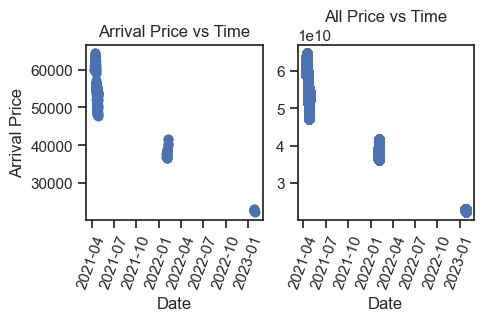

In [352]:
plt.figure(figsize=(5, 5))
plt.subplot(2, 2, 1)
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Arrival Price')
plt.title('Arrival Price vs Time')
plt.scatter(df_btc_to_usd.index, df_btc_to_usd['Arrival_Price'])
plt.subplot(2, 2, 2)
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.title('All Price vs Time')
plt.scatter(trades_btc_usd_buying.index, trades_btc_usd_buying['PriceMillionths'])

Initially, looking at the graph on the left it may look wrong but then on further analysis on the graph on the right, which is the prices of all the trades we see that there are no data points in those periods(late 2021 and late 2022) hence, a random selection which is what is done on the left reflects the right.

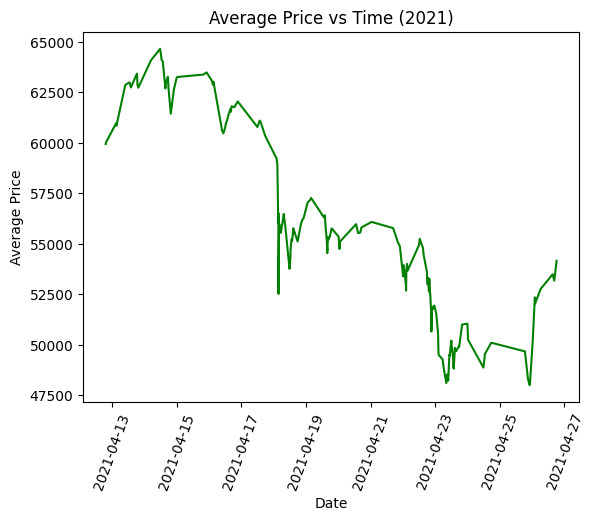

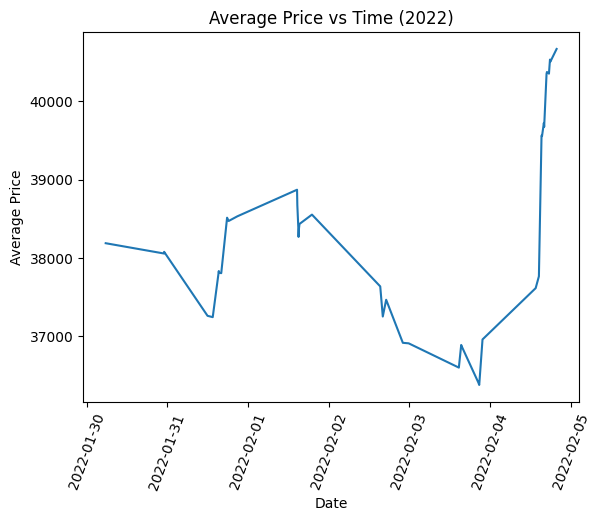

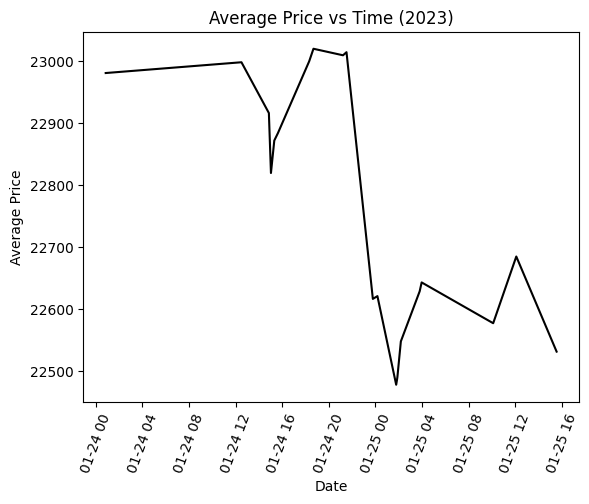

In [74]:

df_btc_to_usd_2021= df_btc_to_usd[:position_2022-1]
df_btc_to_usd_2022= df_btc_to_usd[position_2022:position_2023-1]
df_btc_to_usd_2023= df_btc_to_usd[position_2023:]
plt.xticks(rotation=70)

plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Price vs Time (2021)')

plt.plot(df_btc_to_usd_2021.index, df_btc_to_usd_2021['Average_Price'], color='green')
plt.show()
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Price vs Time (2022)')
plt.plot(df_btc_to_usd_2022.index, df_btc_to_usd_2022['Average_Price'])
plt.show()
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Price vs Time (2023)')
plt.plot(df_btc_to_usd_2023.index, df_btc_to_usd_2023['Average_Price'], color= 'black')

(Very high early 2021, lower late 2021, normal 2022, very low and declining in 2023)
Event Analysis:
The price of Bitcoin has experienced significant fluctuations between 2021 and 2023.

In early 2021, the price of Bitcoin reached very highs, driven by increased demand and the growing popularity of cryptocurrency and adoption of blockchian technology.

Later in 2021, Bitcoin's price experienced a significant pullback, driven by concerns about regulatory risks and the possibility of stricter government regulations. However, the price of Bitcoin recovered in 2022.

In 2023, the price of Bitcoin continued to experience fluctuations, driven by a variety of factors, including changes in market sentiment, economic conditions, and regulatory developments.



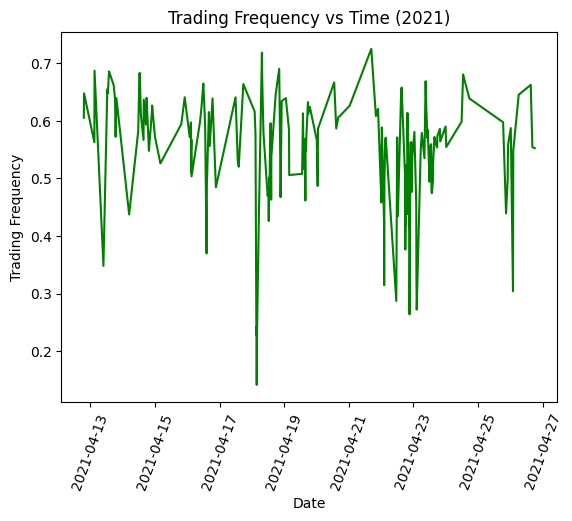

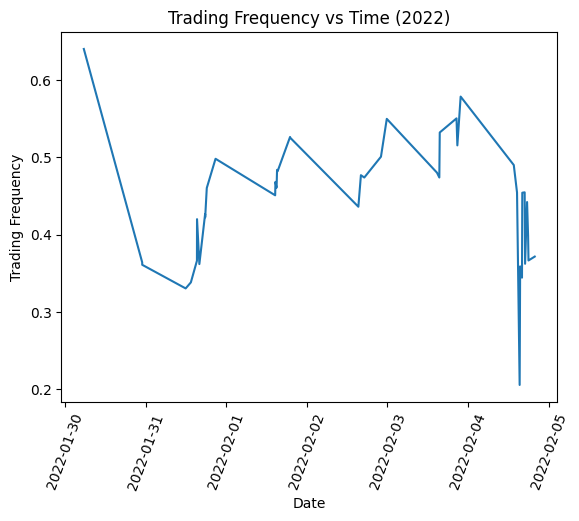

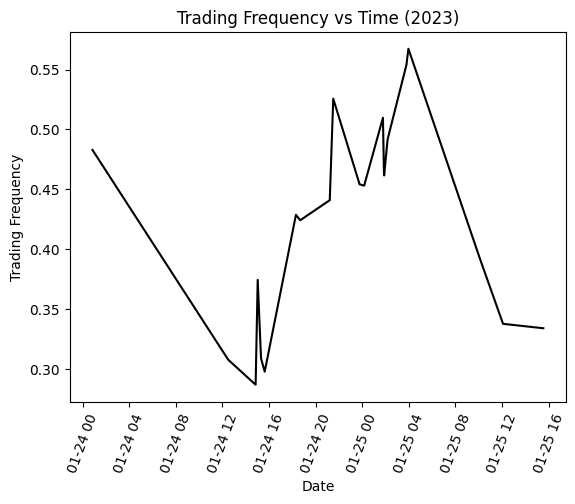

In [75]:
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Trading Frequency')
plt.title('Trading Frequency vs Time (2021)')
plt.plot(df_btc_to_usd_2021.index, df_btc_to_usd_2021['Trading_Frequency'], color='green')
plt.show()
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Trading Frequency')
plt.title('Trading Frequency vs Time (2022)')
plt.plot(df_btc_to_usd_2022.index, df_btc_to_usd_2022['Trading_Frequency'])
plt.show()
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Trading Frequency')
plt.title('Trading Frequency vs Time (2023)')
plt.plot(df_btc_to_usd_2023.index, df_btc_to_usd_2023['Trading_Frequency'], color= 'black')

Here, we see that the trading frequency of buying bitcoins has reduced  slightly from 2021 to 2023. 

This could be due to a few reasons:
1. Market Volatility: Increase in market volatility, reduces trading frequency.
2. Economic conditons.
3. Competitions from other markets
4. Regulatory Developments

In [76]:
def time_slots_df(df):

    night_df= df[df.index.hour <= 8 ]
    rest_df= df[df.index.hour > 8 ]
    morning_df= rest_df[rest_df.index.hour <= 12 ]
    rest_df2= rest_df[rest_df.index.hour > 12 ]
    afternoon_df= rest_df2[rest_df2.index.hour <= 18 ]
    evening_df= rest_df2[rest_df2.index.hour > 18 ]
    m_tf= sum(morning_df['Trading_Frequency'])/len(morning_df['Trading_Frequency'])
    a_tf= sum(afternoon_df['Trading_Frequency'])/len(afternoon_df['Trading_Frequency'])
    e_tf= sum(evening_df['Trading_Frequency'])/len(evening_df['Trading_Frequency'])
    n_tf= sum(night_df['Trading_Frequency'])/len(night_df['Trading_Frequency'])
    list_title= ['morning', 'afternoon', 'evening', 'night']
    list_actual=[m_tf, a_tf, e_tf, n_tf]
    plt.bar(list_title, list_actual, color ='maroon',
        width = 0.4)
 
    plt.xlabel("Time of the Day")
    plt.ylabel("Trading Frequency")
    plt.show()

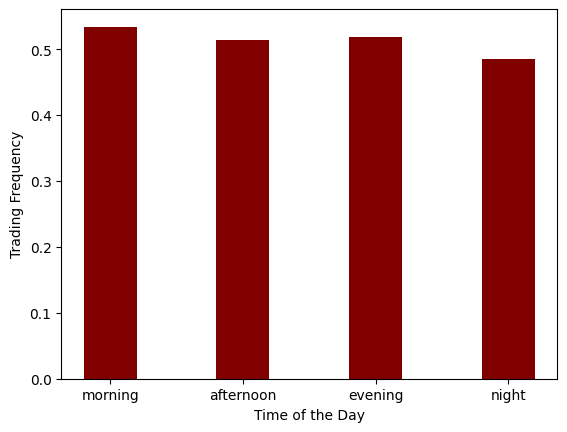

In [77]:
time_slots_df(df_btc_to_usd)

From the above chart, we realize that even though the trading volume of Bitcoin, like any other asset, can be influenced by a variety of factors, including market sentiment, economic conditions, and news events. On average, because Bitcoin is traded 24/7 on various exchanges around the world, its the same.

<AxesSubplot: >

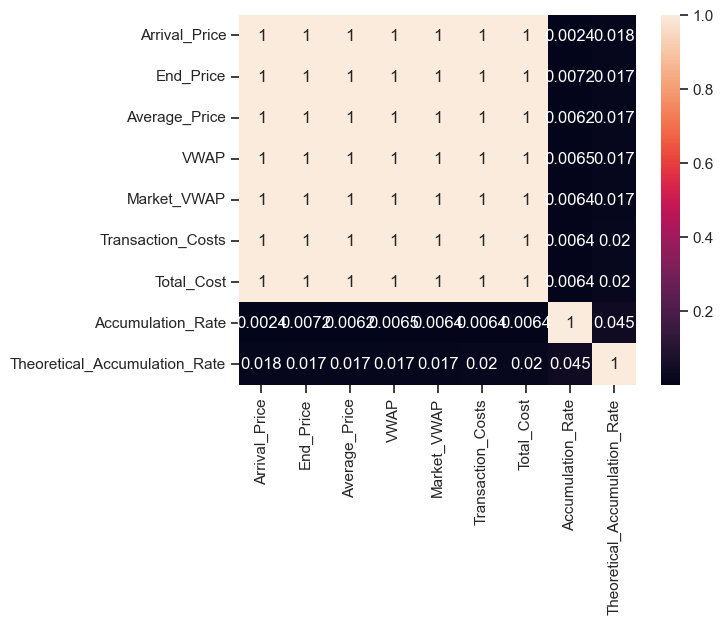

In [399]:
correlation_df= pd.DataFrame()

correlation_df['Arrival_Price']= df_btc_to_usd['Arrival_Price']
correlation_df['End_Price']= df_btc_to_usd['End_Price']
correlation_df['Average_Price']= df_btc_to_usd['Average_Price']
correlation_df['VWAP']= df_btc_to_usd['VWAP']
correlation_df['Market_VWAP']= df_btc_to_usd['Market_VWAP']
correlation_df['Transaction_Costs']= df_btc_to_usd['Transaction_Costs']
correlation_df['Total_Cost']= df_btc_to_usd['Total_Cost']
correlation_df['Accumulation_Rate']= df_btc_to_usd ['Accumulation_Rate']
correlation_df['Theoretical_Accumulation_Rate']= df_btc_to_usd ['Theoretical_Accumulation_Rate']
corr_matrix = correlation_df.corr()
sns.heatmap(corr_matrix, annot=True)

This reiterates what we know, which is how everything is very closely related which each other. the accumulation rate and the theoretical accumulation rate is not related to them. This could be because the price of Bitcoin is influenced by a variety of factors, including supply and demand, investor sentiment, regulatory developments, and economic conditions. The accumulation rate, on the other hand, refers to the rate at which new Bitcoins are added to the total supply, which is determined by the underlying algorithms and protocols of the Bitcoin network.

### Analysing Selling BTC to USD

In [405]:
rate_of_filling_bus, df_btc_to_usd_sell = generate_random(trades_btc_usd_selling, True, trades_btc_usd, 15*60, 0.03, 1, 500)

Q:  1
Time Limit:  900
Participation Rate:  0.03


In [406]:
df_btc_to_usd_sell= df_btc_to_usd_sell.sort_values(by='Start_Time')
df_btc_to_usd_sell =df_btc_to_usd_sell.set_index('Start_Time')
df_btc_to_usd_sell.head()

,End_Time,Arrival_Price,End_Price,Average_Price,Transaction_Time,VWAP,Market_VWAP,Transaction_Costs,Total_Cost,Trading_Frequency,Accumulation_Rate,Theoretical_Accumulation_Rate
Start_Time,,,,,,,,,,,,
2021-04-12 09:39:32.598925,2021-04-12 09:43:17.403399,60186.23,60317.18,60269.954000,0 days 00:03:44.804474,60234.966641,60238.489607,300.991324,60198.264892,0.371972,0.267857,30.000000
2021-04-12 13:34:32.034065,2021-04-12 13:48:48.538739,60418.05,60425.00,60441.078108,0 days 00:14:16.504674,60431.042435,60462.812360,301.548026,60309.605186,0.632296,0.070093,2.857143
2021-04-12 14:44:00.185210,2021-04-12 14:56:54.080249,60119.24,59974.24,60080.356440,0 days 00:12:53.895039,60077.900104,60063.568327,299.805031,59961.006216,0.579374,0.077620,0.006102
2021-04-12 21:20:03.796867,2021-04-12 21:30:27.458461,59825.45,59807.22,59806.296271,0 days 00:10:23.661594,59796.162611,59798.988914,296.823997,59364.799343,0.631393,0.096308,0.010071
2021-04-13 03:05:30.011194,2021-04-13 03:09:36.968068,61043.65,60900.18,60922.247817,0 days 00:04:06.956874,60930.413016,60961.963914,289.002106,57800.421136,0.388795,0.243902,0.015783


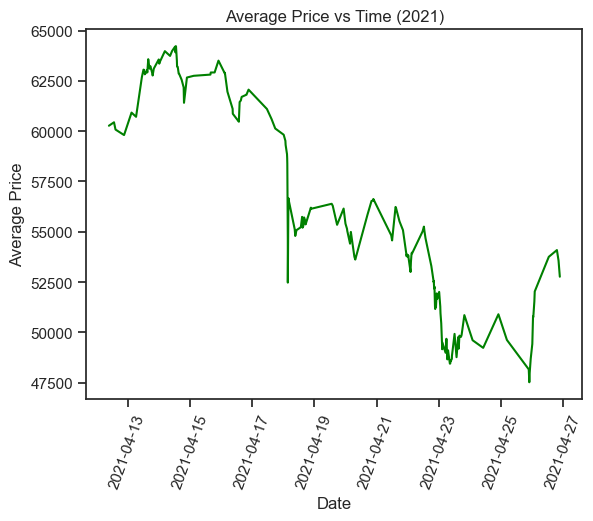

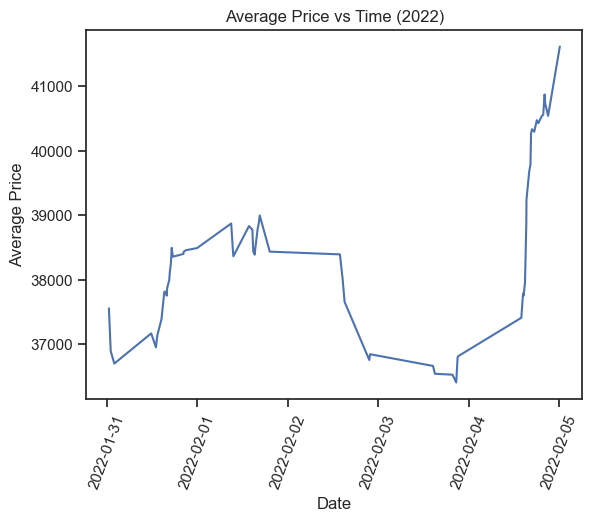

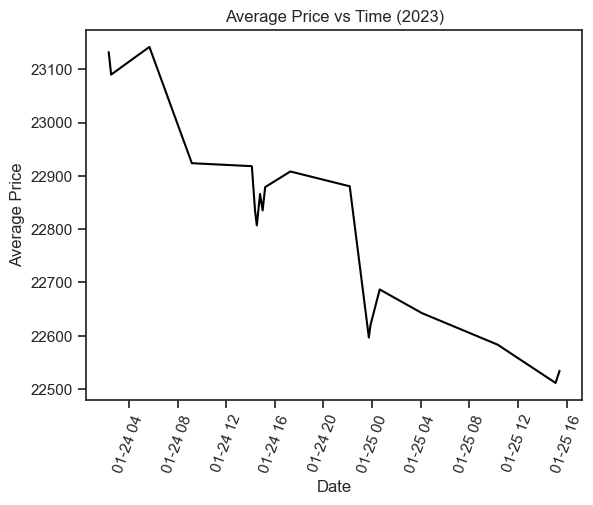

In [408]:
first_day_of_2022= 0
first_day_of_2023= 0
position_2022=0
position_2023=0

for i in range(0, len(df_btc_to_usd_sell)):
    if df_btc_to_usd_sell.index[i].year==2022:
        first_day_of_2022= df_btc_to_usd_sell.index[i]
        position_2022=i
        break
for i in range(0, len(df_btc_to_usd)):
    if df_btc_to_usd_sell.index[i].year==2023:
        first_day_of_2023= df_btc_to_usd_sell.index[i]
        position_2023=i
        break     

df_btc_to_usd_2021= df_btc_to_usd_sell[:position_2022-1]
df_btc_to_usd_2022= df_btc_to_usd_sell[position_2022:position_2023-1]
df_btc_to_usd_2023= df_btc_to_usd_sell[position_2023:]
plt.xticks(rotation=70)

plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Price vs Time (2021)')

plt.plot(df_btc_to_usd_2021.index, df_btc_to_usd_2021['Average_Price'], color='green')
plt.show()
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Price vs Time (2022)')
plt.plot(df_btc_to_usd_2022.index, df_btc_to_usd_2022['Average_Price'])
plt.show()
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Price vs Time (2023)')
plt.plot(df_btc_to_usd_2023.index, df_btc_to_usd_2023['Average_Price'], color= 'black')

The selling trend of prices has similar trends as seen above for the buying of the bitcoins. The reasons for those trends could be similar

### Comparison of Buying and Selling of BTC to usd

In [418]:
average_price_sell= sum(df_btc_to_usd_sell['Average_Price'])/len(df_btc_to_usd_sell['Average_Price'])
average_price_buy= sum(df_btc_to_usd['Average_Price'])/len(df_btc_to_usd['Average_Price'])

trading_frequency_sell= sum(df_btc_to_usd_sell['Trading_Frequency'])/len(df_btc_to_usd_sell['Trading_Frequency'])
trading_frequency_buy= sum(df_btc_to_usd['Trading_Frequency'])/len(df_btc_to_usd['Trading_Frequency'])

accumulation_rate_sell= sum(df_btc_to_usd_sell['Accumulation_Rate'])/len(df_btc_to_usd_sell['Accumulation_Rate'])
accumulation_rate_buy= sum(df_btc_to_usd['Accumulation_Rate'])/len(df_btc_to_usd['Accumulation_Rate'])

<BarContainer object of 2 artists>

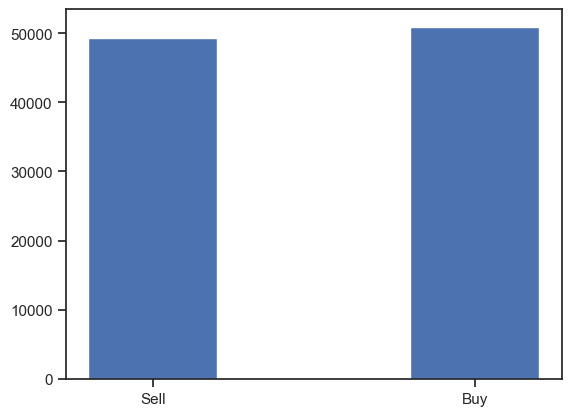

In [416]:
plt.bar( ['Sell', 'Buy'], [average_price_sell, average_price_buy], width=0.4)

Here, the sell price of the bitcoin slightly lower than the buy price of the bitcoin. When the demand for Bitcoin is low, the bid price may be lower than the ask price, which would result in a lower sell price for Bitcoin compared to the buy price. On average there was higher demand in 2021 and lower demand in 2022 and 2023 so it averages out to the same

<BarContainer object of 2 artists>

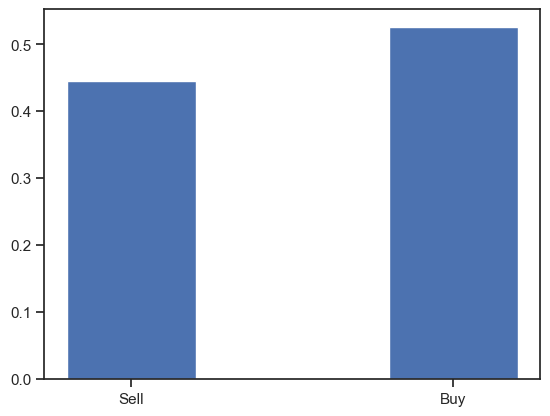

In [417]:
plt.bar( ['Sell', 'Buy'], [trading_frequency_sell, trading_frequency_buy], width=0.4)

The buying frequency id higher which means that there could be more orders put into the exchange from a seller prespective

<BarContainer object of 2 artists>

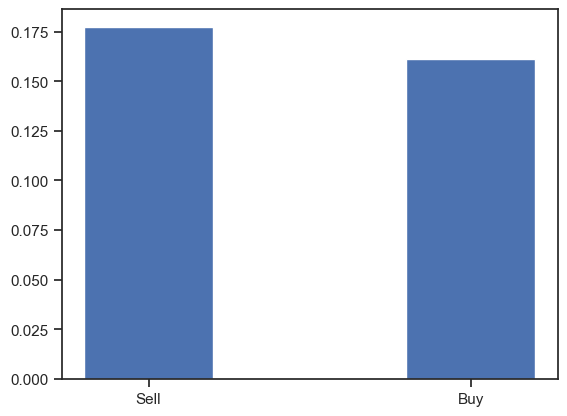

In [420]:
plt.bar( ['Sell', 'Buy'], [accumulation_rate_sell, accumulation_rate_buy], width=0.4)

The accumulation rate of selling is higher, a reason for this could be that the buy order come in a flurry but the sell orders dont necessarily come in a flurry

### Analysis of ETH to BTC Buying

In [430]:
rate_of_filling_ebb, df_eth_to_btc = generate_random(trades_eth_btc_buying, False, trades_btc_usd, 15*60, 0.03, 1, 500)

Q:  1
Time Limit:  900
Participation Rate:  0.03


In [431]:
df_eth_to_btc= df_eth_to_btc.sort_values(by='Start_Time')
df_eth_to_btc = df_eth_to_btc.set_index('Start_Time')
df_eth_to_btc.head()

,End_Time,Arrival_Price,End_Price,Average_Price,Transaction_Time,VWAP,Market_VWAP,Transaction_Costs,Total_Cost,Trading_Frequency,Accumulation_Rate,Theoretical_Accumulation_Rate
Start_Time,,,,,,,,,,,,
2021-04-10 21:35:59.325968,2021-04-10 21:42:54.079128,0.03572,0.03577,0.035730,0 days 00:06:54.753160,0.035730,0.035744,0.000125,0.025064,0.968254,0.144928,2.727273
2021-04-10 21:36:01.068317,2021-04-10 21:42:54.079128,0.03572,0.03577,0.035731,0 days 00:06:53.010811,0.035730,0.035744,0.000125,0.025062,0.967742,0.145278,2.857143
2021-04-10 21:39:54.580414,2021-04-10 21:48:09.641078,0.03572,0.03578,0.035771,0 days 00:08:15.060664,0.035766,0.035771,0.000155,0.030915,0.966667,0.121212,3.157895
2021-04-10 21:45:58.115274,2021-04-10 21:58:17.833395,0.03580,0.03580,0.035790,0 days 00:12:19.718121,0.035784,0.035784,0.000179,0.035782,0.987805,0.081191,1.250000
2021-04-10 22:08:38.631000,2021-04-10 22:23:05.429719,0.03568,0.03570,0.035678,0 days 00:14:26.798719,0.035673,0.035676,0.000162,0.032498,0.961905,0.069284,8.571429


0


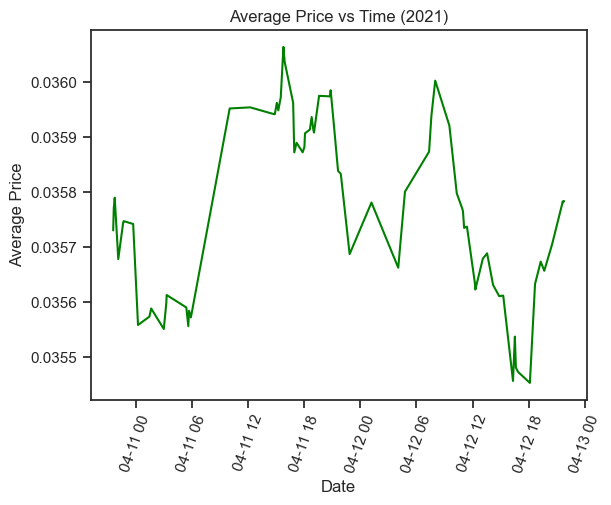

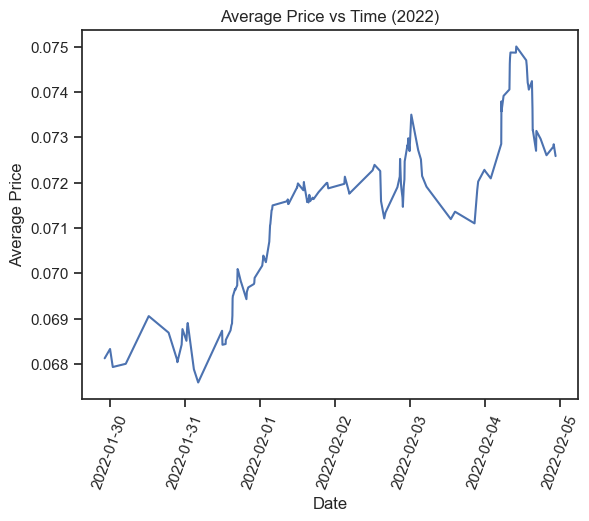

In [437]:
first_day_of_2022= 0
first_day_of_2023= 0
position_2022=0



for i in range(0, len(df_eth_to_btc)):
    if df_eth_to_btc.index[i].year==2022:
        first_day_of_2022= df_eth_to_btc.index[i]
        position_2022=i
        break
for i in range(0, len(df_eth_to_btc)):
    if df_eth_to_btc.index[i].year==2023:
        first_day_of_2023= df_eth_to_btc.index[i]
        position_2023=i
        break  

print(position_2023)
df_btc_to_usd_2021= df_eth_to_btc[:position_2022-1]
df_btc_to_usd_2022= df_eth_to_btc[position_2022:position_2023-1]
df_btc_to_usd_2023= df_eth_to_btc[position_2023+1:]

plt.xticks(rotation=70)

plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Price vs Time (2021)')

plt.plot(df_btc_to_usd_2021.index, df_btc_to_usd_2021['Average_Price'], color='green')
plt.show()
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Price vs Time (2022)')
plt.plot(df_btc_to_usd_2022.index, df_btc_to_usd_2022['Average_Price'])
plt.show()


Here, we see that the price of ethereum was stagnating in 2021, but increased steadily in 2022. 
Several factors contributed to the price increase of Ethereum during this period. Firstly, the growth of the decentralized finance (DeFi) sector, which is built on the Ethereum blockchain, drove up demand for ETH. DeFi applications and protocols, such as stablecoins and yield farming, have grown rapidly in popularity, leading to increased demand for Ethereum as the underlying infrastructure for these projects. And since, etheruem's rise and bitcoin's decline is at the same time. Hence, the growth could be amplfied.

### Analysis of ETH to BTC Selling

In [449]:
rate_of_filling_ebs, df_eth_to_btc_sell = generate_random(trades_eth_btc_selling, False, trades_btc_usd, 15*60, 0.03, 1, 500)

Q:  1
Time Limit:  900
Participation Rate:  0.03


In [450]:
df_eth_to_btc_sell= df_eth_to_btc_sell.sort_values(by='Start_Time')
df_eth_to_btc_sell = df_eth_to_btc_sell.set_index('Start_Time')
df_eth_to_btc_sell.head()

,End_Time,Arrival_Price,End_Price,Average_Price,Transaction_Time,VWAP,Market_VWAP,Transaction_Costs,Total_Cost,Trading_Frequency,Accumulation_Rate,Theoretical_Accumulation_Rate
Start_Time,,,,,,,,,,,,
2021-04-10 21:31:45.526089,2021-04-10 21:43:44.297469,0.03566,0.03578,0.035705,0 days 00:11:58.771380,0.035737,0.035729,0.000178,0.035682,0.885246,0.083565,0.937500
2021-04-10 22:06:05.457601,2021-04-10 22:15:00.262760,0.03574,0.03566,0.035681,0 days 00:08:54.805159,0.035678,0.035678,0.000178,0.035588,0.931818,0.112360,1.428571
2021-04-10 23:19:17.017267,2021-04-10 23:27:07.133010,0.03574,0.03571,0.035724,0 days 00:07:50.115743,0.035721,0.035717,0.000177,0.035401,0.903226,0.127660,0.465116
2021-04-10 23:27:07.133010,2021-04-10 23:29:15.272526,0.03571,0.03571,0.035711,0 days 00:02:08.139516,0.035710,0.035710,0.000168,0.033526,0.857143,0.468750,3.750000
2021-04-11 00:44:36.167166,2021-04-11 00:55:53.302456,0.03545,0.03549,0.035469,0 days 00:11:17.135290,0.035472,0.035475,0.000172,0.034384,0.906977,0.088626,0.937500


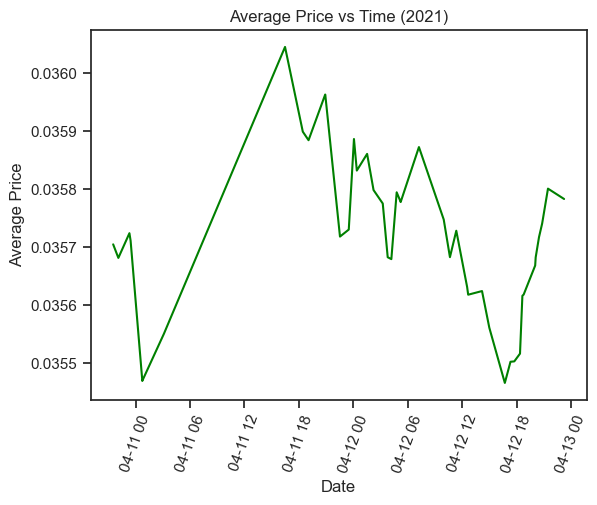

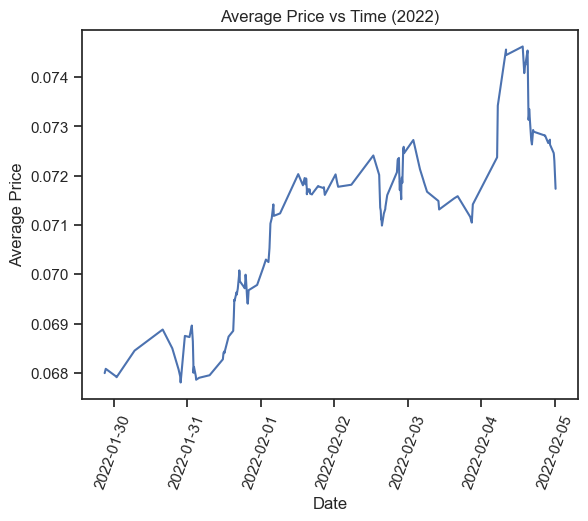

In [451]:
first_day_of_2022= 0
first_day_of_2023= 0
position_2022=0



for i in range(0, len(df_eth_to_btc_sell)):
    if df_eth_to_btc_sell.index[i].year==2022:
        first_day_of_2022= df_eth_to_btc_sell.index[i]
        position_2022=i
        break
for i in range(0, len(df_eth_to_btc_sell)):
    if df_eth_to_btc_sell.index[i].year==2023:
        first_day_of_2023= df_eth_to_btc_sell.index[i]
        position_2023=i
        break  


df_btc_to_usd_2021= df_eth_to_btc_sell[:position_2022-1]
df_btc_to_usd_2022= df_eth_to_btc_sell[position_2022:position_2023-1]
df_btc_to_usd_2023= df_eth_to_btc_sell[position_2023+1:]

plt.xticks(rotation=70)

plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Price vs Time (2021)')

plt.plot(df_btc_to_usd_2021.index, df_btc_to_usd_2021['Average_Price'], color='green')
plt.show()
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Price vs Time (2022)')
plt.plot(df_btc_to_usd_2022.index, df_btc_to_usd_2022['Average_Price'])
plt.show()

The trends are the same as those for buying. Another reasong to explain the trend could be regulatory developments and increasing institutional adoption of cryptocurrency also played a role in the price increase of Ethereum. As cryptocurrency becomes more widely accepted and regulated, investors and institutions may be more likely to invest in the asset, driving up demand and price

### Analysis of ETH to USD Buying

In [452]:
rate_of_filling_eub, df_eth_to_usd = generate_random(trades_eth_usd_buying, False, trades_btc_usd, 15*60, 0.03, 1, 500)

Q:  1
Time Limit:  900
Participation Rate:  0.03


In [454]:
df_eth_to_usd= df_eth_to_usd.sort_values(by='Start_Time')
df_eth_to_usd = df_eth_to_usd.set_index('Start_Time')
df_eth_to_usd.head()

,End_Time,Arrival_Price,End_Price,Average_Price,Transaction_Time,VWAP,Market_VWAP,Transaction_Costs,Total_Cost,Trading_Frequency,Accumulation_Rate,Theoretical_Accumulation_Rate
Start_Time,,,,,,,,,,,,
2021-04-10 21:42:28.359677,2021-04-10 21:43:28.591223,2110.39,2114.00,2111.760263,0 days 00:01:00.231546,2111.579674,2112.468606,8.374913,1674.982511,0.622951,1.000000,0.074992
2021-04-10 23:44:00.453618,2021-04-10 23:45:27.623417,2135.97,2135.32,2136.498202,0 days 00:01:27.169799,2136.582269,2136.512801,10.226250,2045.250027,0.679389,0.689655,100.000000
2021-04-10 23:52:07.998730,2021-04-10 23:53:14.769118,2138.18,2139.95,2138.734861,0 days 00:01:06.770388,2138.853664,2138.662061,10.467936,2093.587161,0.705882,0.909091,7.500000
2021-04-11 00:26:54.649796,2021-04-11 00:29:10.897010,2142.65,2144.71,2142.577742,0 days 00:02:16.247214,2142.669353,2142.603772,10.475096,2095.019260,0.775000,0.441176,60.000000
2021-04-11 01:06:43.696628,2021-04-11 01:08:47.021838,2131.26,2130.26,2130.834000,0 days 00:02:03.325210,2130.853087,2130.688983,10.149909,2029.981740,0.896226,0.487805,8.571429


455


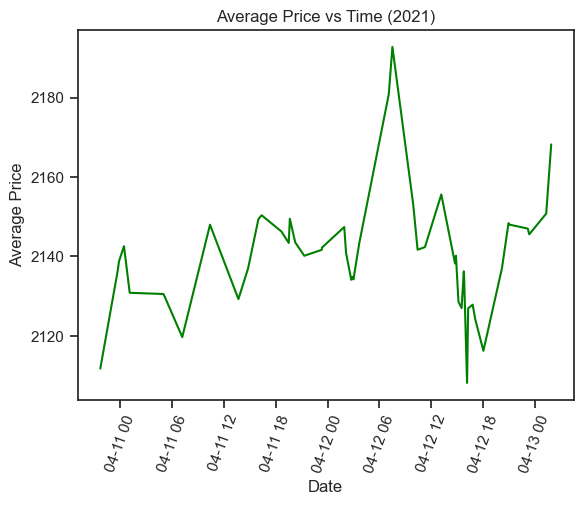

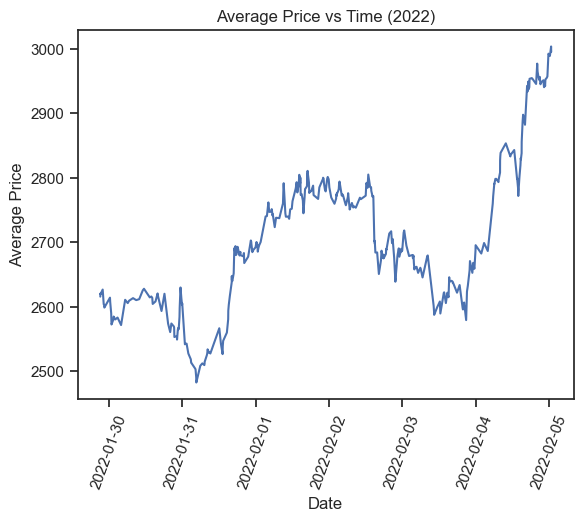

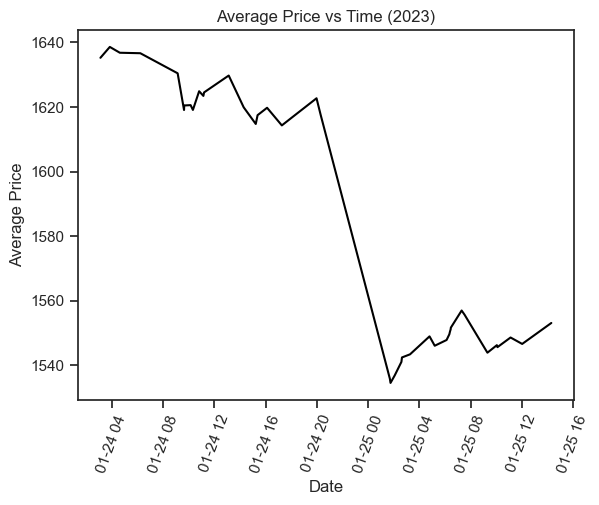

In [456]:
first_day_of_2022= 0
first_day_of_2023= 0
position_2022=0



for i in range(0, len(df_eth_to_usd)):
    if df_eth_to_usd.index[i].year==2022:
        first_day_of_2022= df_eth_to_usd.index[i]
        position_2022=i
        break
for i in range(0, len(df_eth_to_usd)):
    if df_eth_to_usd.index[i].year==2023:
        first_day_of_2023= df_eth_to_usd.index[i]
        position_2023=i
        break  

print(position_2023)
df_btc_to_usd_2021= df_eth_to_usd[:position_2022-1]
df_btc_to_usd_2022= df_eth_to_usd[position_2022:position_2023-1]
df_btc_to_usd_2023= df_eth_to_usd[position_2023+1:]

plt.xticks(rotation=70)

plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Price vs Time (2021)')

plt.plot(df_btc_to_usd_2021.index, df_btc_to_usd_2021['Average_Price'], color='green')
plt.show()
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Price vs Time (2022)')
plt.plot(df_btc_to_usd_2022.index, df_btc_to_usd_2022['Average_Price'])
plt.show()
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Price vs Time (2023)')
plt.plot(df_btc_to_usd_2023.index, df_btc_to_usd_2023['Average_Price'], color= 'black')

The rise in 2021 and 2022 of etheruem has already been explained in the reasoning above. The decline of price in 2023 could be attributed to the cryptocurrency crash. 

### Analysis of ETH to USD Selling

In [457]:
rate_of_filling_eus, df_eth_to_usd_selling = generate_random(trades_eth_usd_selling, False, trades_btc_usd, 15*60, 0.03, 1, 500)

Q:  1
Time Limit:  900
Participation Rate:  0.03


In [458]:
df_eth_to_usd_selling= df_eth_to_usd_selling.sort_values(by='Start_Time')
df_eth_to_usd_selling = df_eth_to_usd_selling.set_index('Start_Time')
df_eth_to_usd_selling.head()

,End_Time,Arrival_Price,End_Price,Average_Price,Transaction_Time,VWAP,Market_VWAP,Transaction_Costs,Total_Cost,Trading_Frequency,Accumulation_Rate,Theoretical_Accumulation_Rate
Start_Time,,,,,,,,,,,,
2021-04-10 21:37:22.662093,2021-04-10 21:43:00.749480,2108.00,2111.38,2110.855323,0 days 00:05:38.087387,2110.774695,2110.633302,10.465249,2093.049768,0.765432,0.177515,2.400000
2021-04-10 21:45:23.660033,2021-04-10 21:46:05.379468,2111.83,2112.00,2112.172727,0 days 00:00:41.719435,2112.173496,2112.034076,3.738640,747.728037,0.785714,1.463415,0.032426
2021-04-10 21:52:21.392587,2021-04-10 21:54:09.013119,2112.12,2113.06,2113.221220,0 days 00:01:47.620532,2113.265001,2113.139281,3.767506,753.501159,0.836735,0.560748,1.764706
2021-04-11 00:22:55.010845,2021-04-11 00:24:14.603089,2139.99,2144.29,2141.030000,0 days 00:01:19.592244,2142.137448,2142.140955,10.690465,2138.093001,0.756757,0.759494,30.000000
2021-04-11 01:09:19.655089,2021-04-11 01:10:22.152370,2129.94,2128.55,2128.260789,0 days 00:01:02.497281,2127.983761,2128.538897,8.846810,1769.361924,0.447059,0.967742,20.000000


443


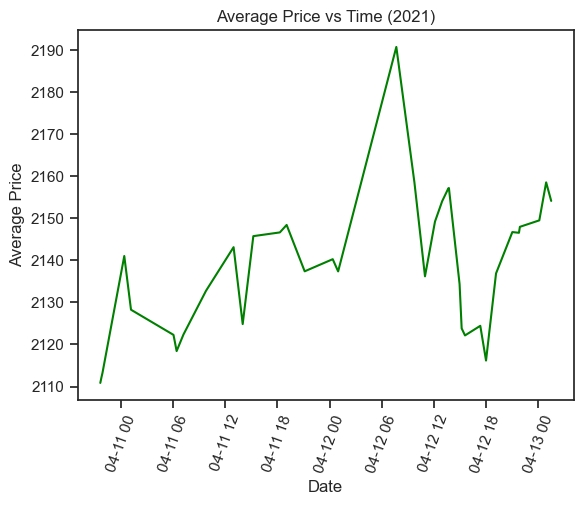

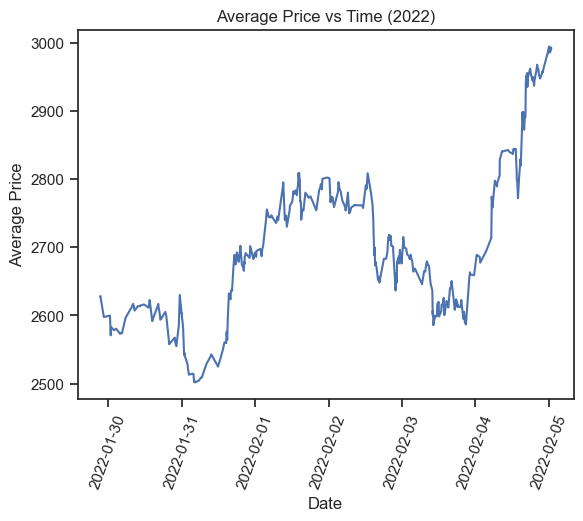

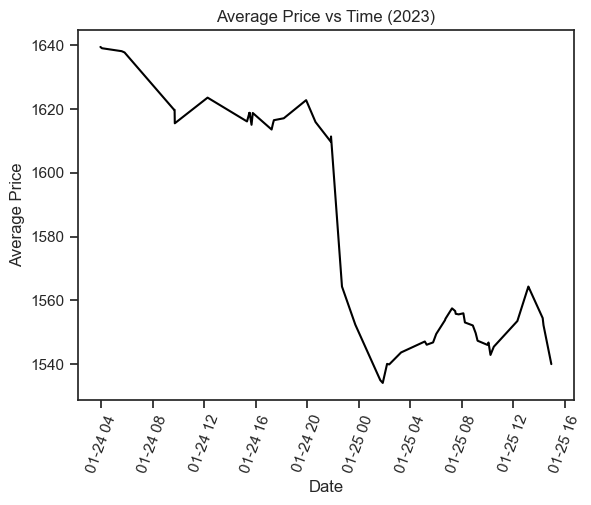

In [459]:
first_day_of_2022= 0
first_day_of_2023= 0
position_2022=0



for i in range(0, len(df_eth_to_usd_selling)):
    if df_eth_to_usd_selling.index[i].year==2022:
        first_day_of_2022= df_eth_to_usd_selling.index[i]
        position_2022=i
        break
for i in range(0, len(df_eth_to_usd_selling)):
    if df_eth_to_usd_selling.index[i].year==2023:
        first_day_of_2023= df_eth_to_usd_selling.index[i]
        position_2023=i
        break  

print(position_2023)
df_btc_to_usd_2021= df_eth_to_usd_selling[:position_2022-1]
df_btc_to_usd_2022= df_eth_to_usd_selling[position_2022:position_2023-1]
df_btc_to_usd_2023= df_eth_to_usd_selling[position_2023+1:]

plt.xticks(rotation=70)

plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Price vs Time (2021)')

plt.plot(df_btc_to_usd_2021.index, df_btc_to_usd_2021['Average_Price'], color='green')
plt.show()
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Price vs Time (2022)')
plt.plot(df_btc_to_usd_2022.index, df_btc_to_usd_2022['Average_Price'])
plt.show()
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Price vs Time (2023)')
plt.plot(df_btc_to_usd_2023.index, df_btc_to_usd_2023['Average_Price'], color= 'black')

### Analysing Liquidity of all the three pairs

<BarContainer object of 6 artists>

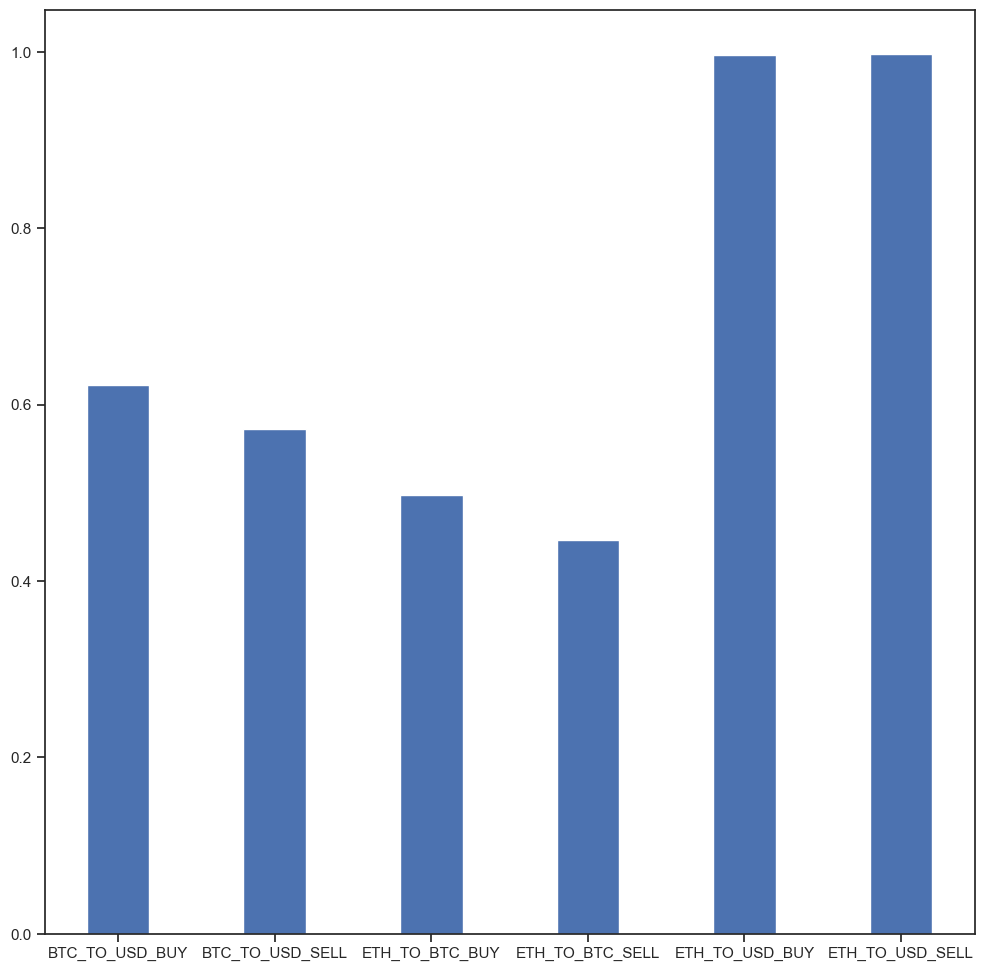

In [467]:
list_uc= [rate_of_filling, rate_of_filling_bus, rate_of_filling_ebb, rate_of_filling_ebs, rate_of_filling_eub, rate_of_filling_eus]
list_uc_names= ['BTC_TO_USD_BUY', 'BTC_TO_USD_SELL', 'ETH_TO_BTC_BUY', 'ETH_TO_BTC_SELL', 'ETH_TO_USD_BUY', 'ETH_TO_USD_SELL']
plt.figure(figsize=(12, 12))
plt.bar( list_uc_names, list_uc, width=0.4)

We measure the liquidity of the three pairs by analyzing the rate of filling, that is if an order is given what is the probability that it will be filled within the time_limit. Here, we see that is is easiest to buy and sell etherium, that is once an order has been put it almost with a 100% certaintity the order would get executed. Hence it is much more liquid. Hoever, etherium to bitcoin has the lowest liquidity

<BarContainer object of 6 artists>

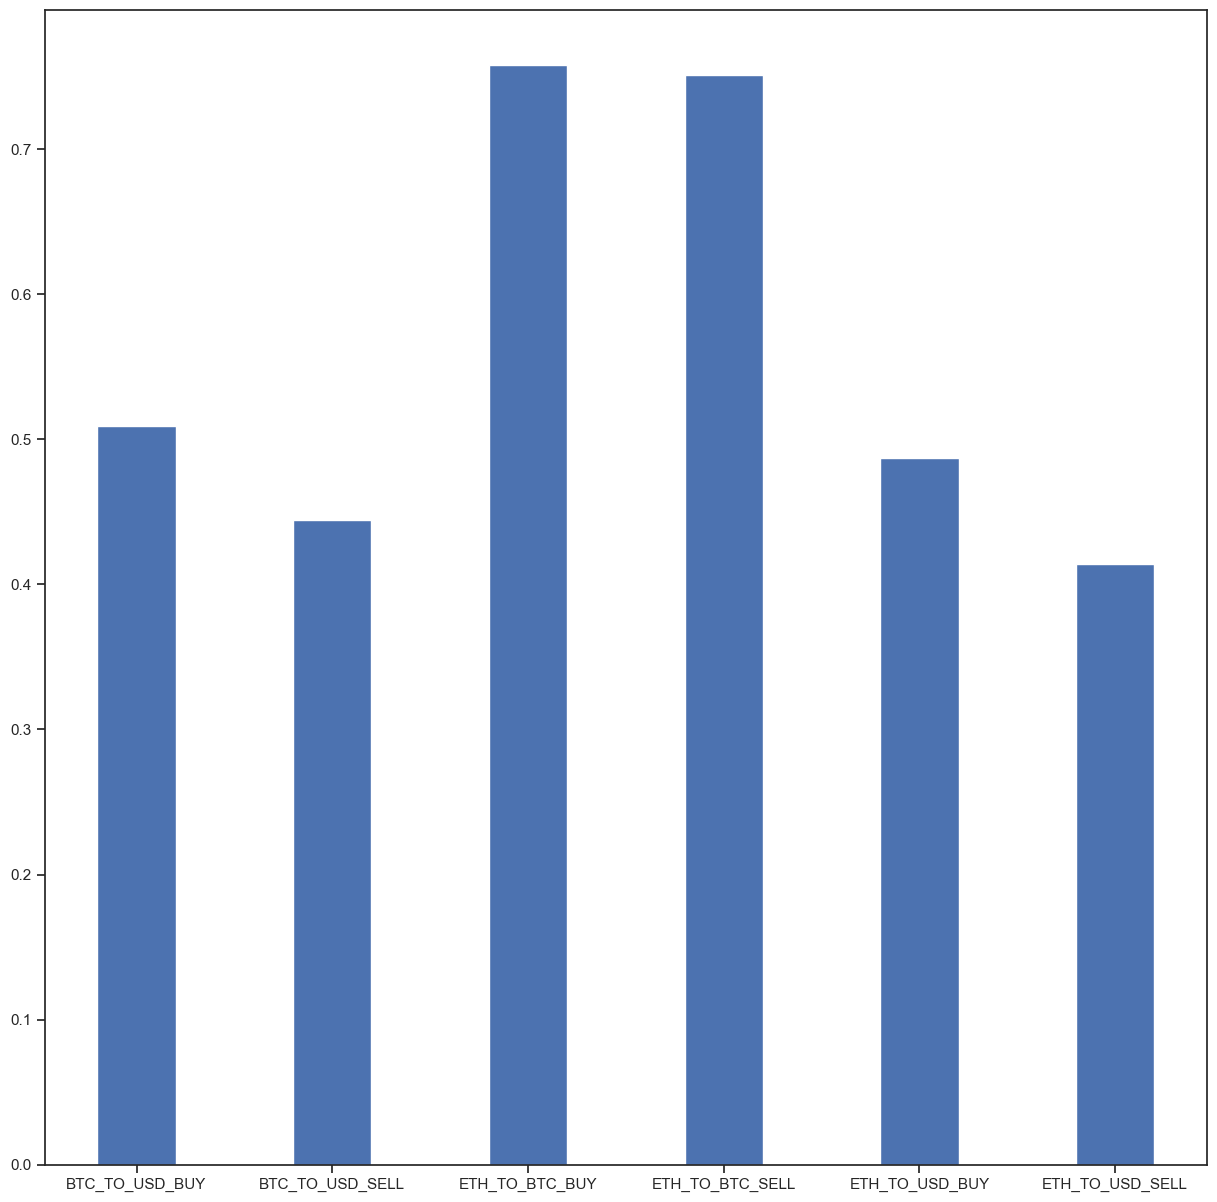

In [468]:
list_uc= [sum(df_btc_to_usd['Trading_Frequency'])/len(df_btc_to_usd['Trading_Frequency']), sum(df_btc_to_usd_sell['Trading_Frequency'])/len(df_btc_to_usd_sell['Trading_Frequency']), sum(df_eth_to_btc['Trading_Frequency'])/len(df_eth_to_btc['Trading_Frequency']), sum(df_eth_to_btc_sell['Trading_Frequency'])/len(df_eth_to_btc_sell['Trading_Frequency']), sum(df_eth_to_usd['Trading_Frequency'])/len(df_eth_to_usd['Trading_Frequency']), sum(df_eth_to_usd_selling['Trading_Frequency'])/len(df_eth_to_usd_selling['Trading_Frequency'])]
list_uc_names= ['BTC_TO_USD_BUY', 'BTC_TO_USD_SELL', 'ETH_TO_BTC_BUY', 'ETH_TO_BTC_SELL', 'ETH_TO_USD_BUY', 'ETH_TO_USD_SELL']
plt.figure(figsize=(15, 15))
plt.bar( list_uc_names, list_uc, width=0.4)

Trading Frequency shows that the btc to usd has the highest trading frequency hence the lowest flurry

In [86]:
def relationship_between_Q_and_probability_of_finishing():
    Q= [0.1, 0.5, 0.75, 1, 5]
    rate_of_filling_list=[]
    deviation_from_expected_accumulation=[]
    for q in Q:
        rate_of_filling, df_btc_to_usd = generate_random(trades_btc_usd_buying, True, trades_btc_usd, 15*60, 0.03, q, 500)
        deviation_from_expected_accumulation.append((df_btc_to_usd['Theoretical_Accumulation_Rate']-df_btc_to_usd['Accumulation_Rate'])/df_btc_to_usd['Theoretical_Accumulation_Rate'])
        rate_of_filling_list.append(rate_of_filling)
     
     
    return rate_of_filling_list, deviation_from_expected_accumulation

In [87]:
rate_of_filling_list, deviation_from_expected_accumulation= relationship_between_Q_and_probability_of_finishing()

Q:  0.1
Time Limit:  900
Participation Rate:  0.03
Q:  0.5
Time Limit:  900
Participation Rate:  0.03
Q:  0.75
Time Limit:  900
Participation Rate:  0.03
Q:  1
Time Limit:  900
Participation Rate:  0.03
Q:  5
Time Limit:  900
Participation Rate:  0.03


Text(0.5, 1.0, 'Q against Rate of Filling')

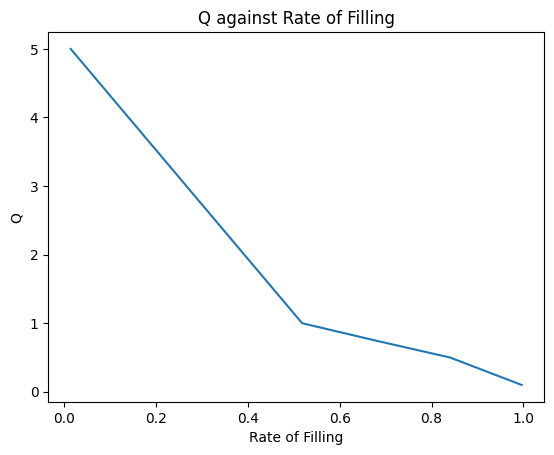

In [89]:
plt.plot(rate_of_filling_list, [0.1, 0.5, 0.75, 1, 5])
plt.xlabel('Rate of Filling')
plt.ylabel('Q')
plt.title('Q against Rate of Filling')

The rate_of_filling is proportional to the Q. However, this could be a sort of curved relationship, there is a drastic difference in the filling rate initially and then it curves and evens out closer to 1.

In [93]:
dfea=[]
for i in range(0, len(deviation_from_expected_accumulation)):
    dfea.append(sum(deviation_from_expected_accumulation)/len(deviation_from_expected_accumulation))

Text(0.5, 1.0, 'Q against Deviation from Expected Accumulation')

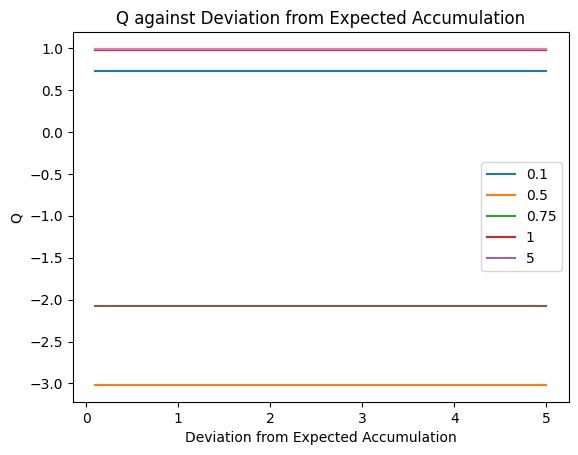

In [101]:
plt.plot([0.1, 0.5, 0.75, 1, 5], dfea)
plt.xlabel('Deviation from Expected Accumulation')
plt.ylabel('Q')
plt.legend([0.1, 0.5, 0.75, 1, 5])
plt.title('Q against Deviation from Expected Accumulation')

From the graph here we cannot narrow down on the relation between Q and the devation from the average expected accumulation. The highest deviation is for the quantity of 5 but the lowest is for 0.5 and not 0.1. Hence, this should be explore more

In [106]:
def transaction_costs_proportion_of_notional():
    rate_of_filling, df_eu = generate_random(trades_eth_usd_selling, True, trades_eth_usd, 15*60, 0.03, 1, 500)
    a= df_eu['Total_Cost']/df_eu['Transaction_Costs']
    plt.plot(df_eu['Total_Cost'], df_eu['Transaction_Costs'])
    plt.show()
    rate_of_filling, df_eb = generate_random(trades_eth_btc_selling, True, trades_eth_btc, 15*60, 0.03, 1, 500)
    plt.plot(df_eb['Total_Cost'], df_eb['Transaction_Costs'])
    plt.show()

Q:  1
Time Limit:  900
Participation Rate:  0.03


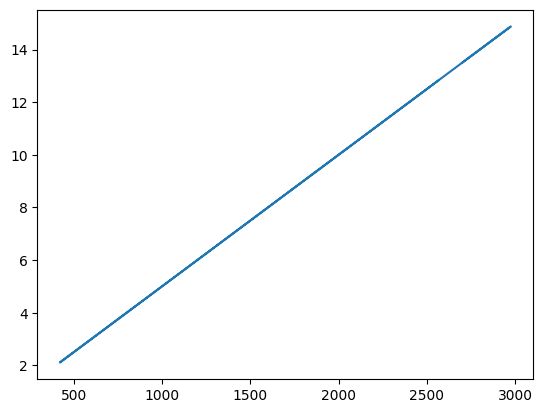

Q:  1
Time Limit:  900
Participation Rate:  0.03


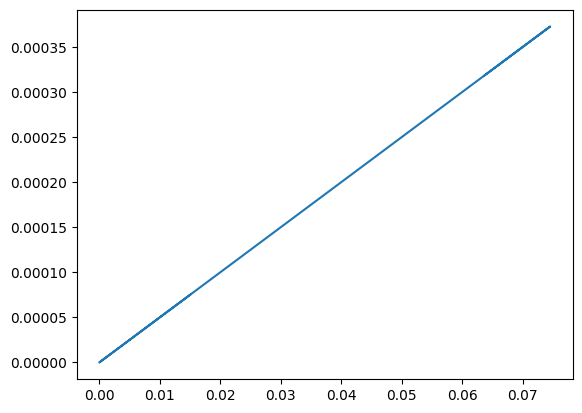

In [107]:
transaction_costs_proportion_of_notional()

This is just a test to see that the transaction costs are proprotional to the notional, which as demonstrated from here are.

#### Parameter Analysis:

#### Participation Rate:
If the participation rate is high, it means that a large portion of the shares are being actively traded, which can increase the accuracy of the VWAP calculation as it is based on the average price of all trades executed over a specified period. A high participation rate can result in a VWAP that is more representative of the overall market conditions.

On the other hand, if the participation rate is low, it means that only a small portion of the shares are being actively traded, which can reduce the accuracy of the VWAP calculation. A low participation rate can result in a VWAP that may not be representative of the market conditions and may deviate significantly from the actual average price.

Therefore, the participation rate can affect the calculation of the VWAP by impacting the number of shares being traded and the representativeness of the VWAP as a measure of the average price in the market.

#### Chunk rate:
If the chunk rate is high, it means that the trades are executed in larger quantities and at a faster pace, which can have an impact on the calculation of the VWAP. This can cause the VWAP to fluctuate more rapidly, potentially leading to a higher deviation from the average price. On the other hand, a lower chunk rate means that trades are executed in smaller quantities and at a slower pace, which can result in a smoother calculation of the VWAP.
Therefore, the chunk rate can impact the accuracy of the VWAP calculation, as it affects the distribution of trades over time and the weighting of the average price by trade volume.

### Conclusion

1. Triangluar relationship
We investigated the triangluar relation between etherium, bitcoin and usd and were able to see some trends and make some events anaysis or give an economic inuition as to why sucha relationship possibly exists.

2. VWAP in general
Implemented the algorithm. We learned about the market trends, price performance and trading volumes. In conclusion, VWAP is a useful technical indicator that can provide valuable information on the price trends, performance, and trading volume of a security, helping traders and investors make informed investment decisions.

3. Other averages
It would be interested as a future wok to see how other weighted average prices would behave and if it possible to get more or different insights from that.